# **<center>Capstone Project Modul 3 – Machine Learning<center>**
<center><em>Muhammad Arief Munazat</em></center>
<center><em>JCDSAH 024</em></center>

---
# **Blueprint of E-Commerce Customer Churn Prediction**
---

*Apply Several Preprocessing Methods, Modeling, and Hyperparameter Tuning for E-Commerce Churn Prediction*

## **1. Data Overview**

* **Dataset**: [data_ecommerce_customer_churn.csv](https://drive.google.com/file/d/1fbpOAS-ncGueI0WlwRpXpco07yYNb67n/view?usp=sharing)
* **Target Variable**: `Churn`

  * `0` = Customer aktif
  * `1` = Customer churn
* **Problem Type**: Supervised Learning – Binary Classification

---

## **2. Feature Definition**

* **Input Features**: seluruh variabel selain `Churn`
* **Target**: `Churn`
  (digunakan hanya sebagai label, tidak dimasukkan ke dalam model)

---

## **3. Train–Test Split**

Data dibagi menjadi data latih dan data uji untuk memisahkan proses pembelajaran model dan evaluasi performa.

* **Split Ratio**: 80% training – 20% testing
* **random_state**: 42
* **stratify**: `y`
  (untuk menjaga proporsi churn dan non-churn tetap seimbang)

---

## **4. Preprocessing Strategy**

*(Defined before split, fitted only on training data)*

Seluruh proses preprocessing didefinisikan dalam satu **pipeline** dan **hanya di-fit menggunakan data training** untuk mencegah data leakage.

### **4.1 Missing Value Handling**

* **Numerical features** → `SimpleImputer(strategy="median")`
* **Categorical features** → `SimpleImputer(strategy="most_frequent")`

### **4.2 Categorical Encoding**

* **One-Hot Encoding**

  * `MaritalStatus`
  * `PreferedOrderCat`
* **Binary Encoding**

  * `Complain`
    (binary categorical feature)

### **4.3 Numerical Features (No Encoding)**

* `Tenure`
* `WarehouseToHome`
* `NumberOfDeviceRegistered`
* `NumberOfAddress`
* `DaySinceLastOrder`
* `CashbackAmount`
* `SatisfactionScore`

### **4.4 Excluded Feature**

* `Churn`
  (digunakan sebagai target, tidak dimasukkan ke dalam preprocessing pipeline)

> **Catatan penting:**
> Semua preprocessing di-fit pada data training dan hanya di-transform pada data testing untuk memastikan evaluasi model bersifat objektif dan bebas dari data leakage.

---

## **5. Modeling**

Beberapa model berbasis classification digunakan untuk memenuhi problem business case ini.

1. **Models Evaluated**
    - Decision Tree Classifier
    - AdaBoost Classifier
    - Gradient Boosting Classifier
    - Random Forest
    - XGBoost

2. **Evaluation metrics:**
    - Precision
    - Recall
    - F1-score
    - Feature importance analysis

---

## **6. Model Selection & Hyperparameter Tuning**

### **6.1 Model Selection**

- Menggunakan `GridSearchCV`
- Model yang dibandingkan:
  - Decision Tree
  - AdaBoost
  - Gradient Boosting
  - Random Forest
  - XGBoost
- **Optimization metric**: F1-score
- **Cross-validation**: Stratified 5-Fold

### **6.2 Hyperparameter Tuning**

* Parameter yang dituning:

  * `n_estimators`
  * `max_depth`
  * `learning_rate`
* Tujuan:

  * Memaksimalkan F1-score
  * Menyeimbangkan precision dan recall pada kasus churn

> Proses tuning dilakukan **hanya pada data training** menggunakan cross-validation.

---

## **7. Final Evaluation**

Evaluasi akhir dilakukan menggunakan **data test yang benar-benar tidak terlihat oleh model**.

* Metrics:

  * Precision
  * Recall
  * F1-score
  * **ROC-AUC**
  * **Precision–Recall Curve**
* Perbandingan performa:
  * Sebelum hyperparameter tuning
  * Setelah hyperparameter tuning

---

## **8. Business Interpretation**

* Mengidentifikasi **faktor utama penyebab churn** berdasarkan feature importance
* Menerjemahkan output model menjadi rekomendasi bisnis, seperti:

  * Strategi customer retention
  * Actionable Churn Mitigation Plan
  * Sistem early warning untuk pelanggan berisiko churn

---
# **Kerangka Berfikir**
---

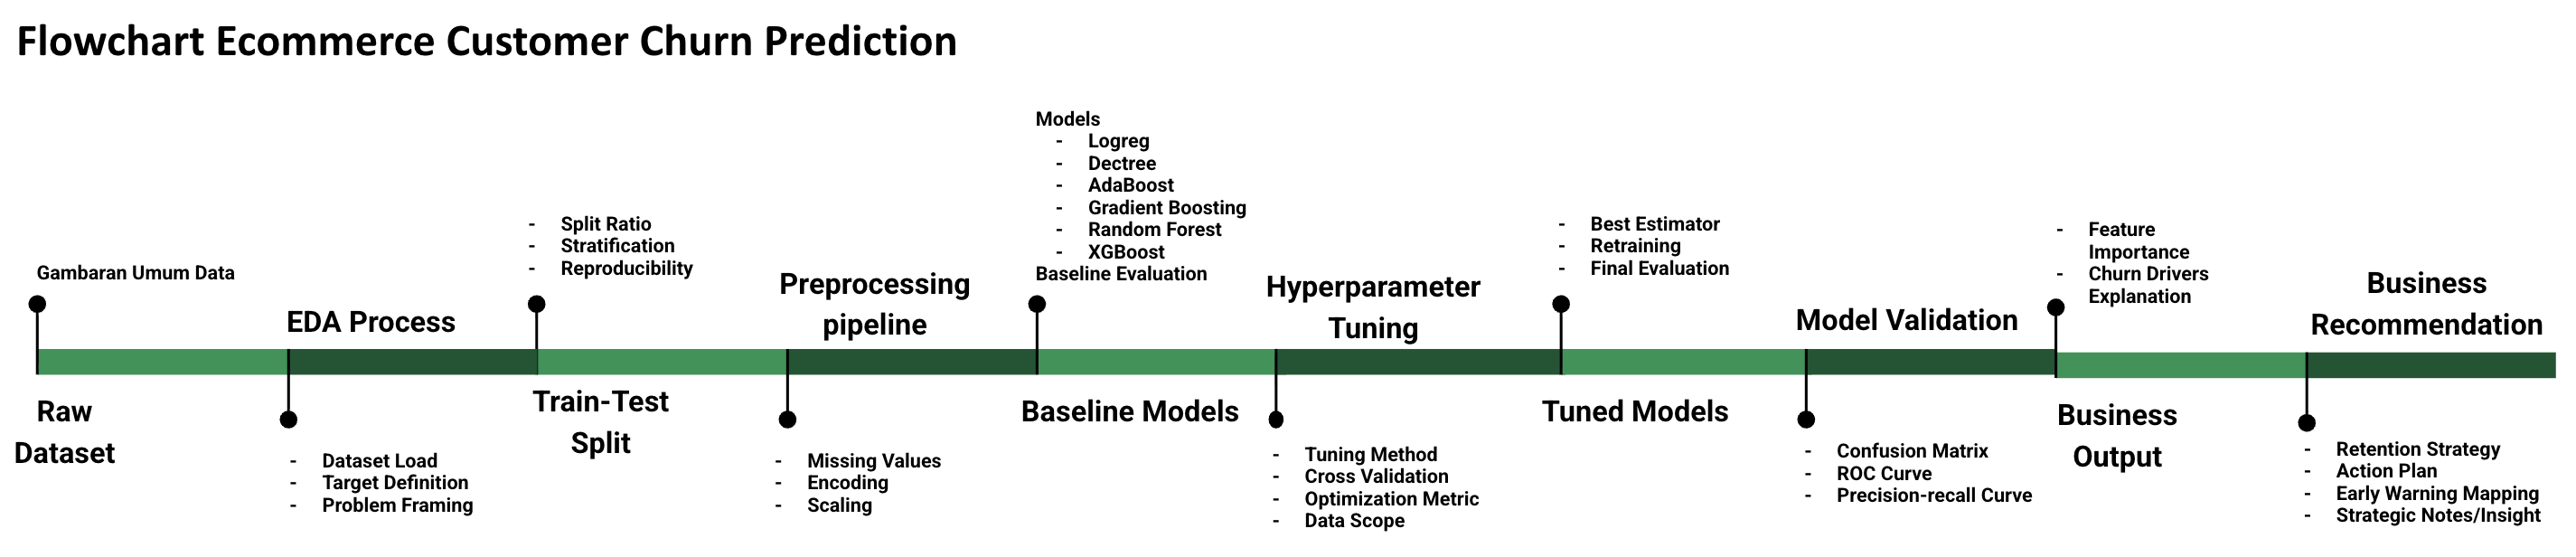

---
# **Import Library Preparation**
---

- *Blok kode ini mengimpor seluruh library yang diperlukan untuk membangun end-to-end machine learning pipeline dalam memprediksi customer churn.*
- *Pipeline mencakup data preprocessing, feature encoding, model training, hyperparameter tuning, serta evaluasi performa menggunakan metrik yang relevan untuk kasus data imbalance seperti churn prediction.*

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Splitting & Model Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold,cross_val_score, cross_validate

# Pipeline & Feature Transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Encoding & Scaling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
import category_encoders as ce

# Model Classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,  RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
)
from sklearn.metrics import roc_curve, precision_recall_curve, auc

---
# **Gambaran Umum Data**
---

## *Konteks Business*

Perusahaan e-commerce ingin ***memprediksi pelanggan yang berpotensi churn (berhenti berlangganan/membeli)*** agar dapat memberikan penawaran atau promosi yang sesuai untuk mempertahankan mereka (Retensi).

## *Fitur-Fitur Dataset*


| No. | Nama Fitur                  | Keterangan                                                                |
|-----|-----------------------------|---------------------------------------------------------------------------|
| 1   | Tenure                      | Lama menjadi pelanggan (dalam bulan/tahun).                               |
| 2   | WarehouseToHome             | Jarak gudang ke rumah pelanggan.                                          |
| 3   | NumberOfDeviceRegistered    | Jumlah perangkat yang terdaftar atas nama pelanggan.                      |
| 4   | PreferedOrderCat            | Kategori pesanan favorit pelanggan dalam bulan terakhir.                  |
| 5   | SatisfactionScore           | Skor kepuasan pelanggan terhadap layanan (skala numerik atau kategorik).  |
| 6   | MaritalStatus               | Status pernikahan pelanggan.                                              |
| 7   | NumberOfAddress             | Jumlah alamat yang tercatat untuk pelanggan.                              |
| 8   | Complaint                   | Apakah ada komplain yang diajukan bulan lalu (ya/tidak).                  |
| 9   | DaySinceLastOrder           | Hari sejak pesanan terakhir.                                              |
| 10  | CashbackAmount              | Rata-rata cashback yang diterima bulan lalu.                              |
| 11  | Churn                       | **Target variabel** – status churn (1 = churn, 0 = tidak churn).          |

**Atribute Information Dari Dataset:**
| Attribute Name           | Jenis Data (Statistik) | Jenis Data (ML) |
| ------------------------ | ---------------------- | --------------- |
| Tenure                   | Numerik (Diskrit)      | Numerical       |
| WarehouseToHome          | Numerik (Diskrit)      | Numerical       |
| NumberOfDeviceRegistered | Numerik (Diskrit)      | Numerical       |
| PreferedOrderCat         | Kategorikal (Nominal)  | Categorical     |
| SatisfactionScore        | Ordinal                | Ordinal         |
| MaritalStatus            | Kategorikal (Nominal)  | Categorical     |
| NumberOfAddress          | Numerik (Diskrit)      | Numerical       |
| Complain                 | Biner                  | Binary          |
| DaySinceLastOrder        | Numerik (Diskrit)      | Numerical       |
| CashbackAmount           | Numerik (Kontinu)      | Numerical       |
| Churn                    | Biner (Target)         | Label           |

**Kategori Value:**
- PreferOrderCat :
    - Laptop & Accessory
    - Mobile
    - Fashion
    - Mobile Phone
    - Grocery
    - Others
- MaritalStatus :
    - Single
    - Married
    - Divorced

**Tujuan Analisis untuk CP 3 (Machine Learning) ini:**  
- Membangun **model klasifikasi** untuk memprediksi churn pelanggan.  
- Mengidentifikasi faktor-faktor paling berpengaruh terhadap churn.  
- Memberikan rekomendasi strategi retensi berdasarkan insight dari model.

---
# **Exploratory Data Analysis (EDA)**
---
*Untuk melihat (check) Dataset, Ukuran, Kolom, Tipe Data, & Data Understanding*

### *Load Data Set*

In [2]:
# Load data
df = pd.read_csv('data_ecommerce_customer_churn.csv')

# Preview data
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


**Interpretasi dari data overview:**
- Dataset memiliki 3.941 baris (observasi pelanggan)
- Terdiri dari 11 kolom (fitur/variabel)
- Artinya, setiap baris merepresentasikan 1 pelanggan e-commerce, dan setiap kolom adalah atribut perilaku atau karakteristik pelanggan.

Confusion Matrix - Baseline (all non-churn):
 [[3267    0]
 [ 674    0]]


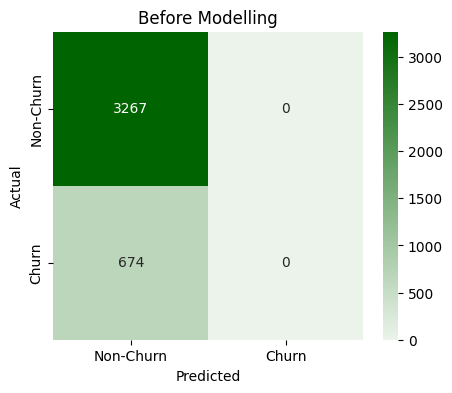

In [3]:
from sklearn.metrics import confusion_matrix
y_actual = df['Churn']

# Asumsi prediksi awal: semua non-churn
y_pred_baseline = [0] * len(y_actual)

# Confusion Matrix
cm_baseline = confusion_matrix(y_actual, y_pred_baseline)
print("Confusion Matrix - Baseline (all non-churn):\n", cm_baseline)

# Visualisasi
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_baseline, 
    annot=True, 
    fmt='d', 
    cmap=sns.light_palette("#006400", as_cmap=True), 
    xticklabels=['Non-Churn','Churn'], 
    yticklabels=['Non-Churn','Churn']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Before Modelling')
plt.show()


**Interpretasi Confusion Metrix sebelum modelling:**
- True Negative (TN) = 3267 → pelanggan non-churn diprediksi benar.
- False Positive (FP) = 0 → tidak ada pelanggan non-churn yang salah diprediksi churn (karena semua prediksi = non-churn).
- False Negative (FN) = 674 → pelanggan yang sebenarnya churn tidak terdeteksi sama sekali.
- True Positive (TP) = 0 → tidak ada pelanggan churn yang berhasil diprediksi.

Penjelasan singkat:
> - Baseline tanpa model = “blind” terhadap churn
> - Semua pelanggan dianggap non-churn.
> - Tidak ada pelanggan berisiko yang tertangkap (TP = 0).
> - Early-stage churn tidak bisa diintervensi, sehingga strategi retention tidak efektif.

### *Data Structure & Types*

In [4]:
# Data Structure & Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


**Interpretasi dari data structure & types:**

Tabel 1. Struktur Umum Dataset

| Aspek         | Keterangan              |
| ------------- | ----------------------- |
| Jumlah data   | 3.941 baris (pelanggan) |
| Jumlah kolom  | 11 fitur                |
| Ukuran data   | ±338.8 KB               |
| Jenis masalah | Klasifikasi (Churn)     |

Tabel 2. Tipe Data

| Tipe Data | Jumlah Kolom | Penjelasan           |
| --------- | ------------ | -------------------- |
| float64   | 4            | Data numerik kontinu |
| int64     | 5            | Data numerik diskrit |
| object    | 2            | Data kategorikal     |

Tabel 3. Missing Values

| Kolom             | Jumlah Missing |
| ----------------- | -------------- |
| Tenure            | 194            |
| WarehouseToHome   | 169            |
| DaySinceLastOrder | 213            |
| Kolom lain        | 0              |

Tabel 4. Klasifikasi Fitur

| Kategori             | Kolom                                                                                                                    |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| Numerical Features   | Tenure, WarehouseToHome, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, DaySinceLastOrder, CashbackAmount |
| Categorical Features | PreferedOrderCat, MaritalStatus                                                                                          |
| Target Variable      | Churn (0 = tidak churn, 1 = churn)                                                                                       |

Tabel 5. Insight Awal untuk Modeling

| Aspek                  | Penjelasan                                                           |
| ---------------------- | -------------------------------------------------------------------- |
| Kesiapan data          | Cocok untuk supervised learning                                      |
| Isu utama              | Missing values pada beberapa kolom                                   |
| Tindakan preprocessing | Imputasi, encoding, scaling                                |
| Model yang sesuai      | Logistic Regression, Decision Tree, Random Forest, Gradient Boosting |

### *Analisa Statistik Deskriptif*

In [5]:
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


**Interpretasi Ringkasan Statistik Deskriptif**
| Fitur                        | Ringkasan Statistik Utama               | Interpretasi                                                                                                                                                                                  |
| ---------------------------- | --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Tenure**                   | Mean ≈ 10, Median = 9, Max = 61         | Rata-rata customer telah berlangganan sekitar 10 bulan, namun median yang lebih rendah menunjukkan distribusi condong ke kanan dengan sebagian kecil customer memiliki tenure sangat panjang. |
| **WarehouseToHome**          | Mean ≈ 15.7, Median = 14, Max = 127     | Mayoritas customer tinggal relatif dekat dengan gudang, tetapi terdapat nilai ekstrem yang mencerminkan variasi jarak geografis yang cukup besar.                                             |
| **NumberOfDeviceRegistered** | Mean ≈ 3.7, Median = 4                  | Jumlah device yang terdaftar relatif stabil di kisaran 3–4 device, menunjukkan pola penggunaan multi-device yang konsisten.                                                                   |
| **SatisfactionScore**        | Mean ≈ 3.1, Median = 3, Range = 1–5     | Tingkat kepuasan customer berada pada level menengah, dengan sebaran nilai yang relatif merata pada skala penilaian.                                                                          |
| **NumberOfAddress**          | Mean ≈ 4.2, Median = 3, Max = 22        | Sebagian besar customer memiliki sedikit alamat, namun terdapat customer dengan jumlah alamat yang jauh lebih banyak, menunjukkan heterogenitas perilaku transaksi.                           |
| **Complain**                 | Mean ≈ 0.28, Median = 0                 | Mayoritas customer tidak pernah melakukan komplain, dan hanya sebagian kecil customer yang pernah menyampaikan keluhan.                                                                       |
| **DaySinceLastOrder**        | Mean ≈ 4.5, Median = 3, Max = 46        | Customer umumnya melakukan transaksi relatif baru, namun terdapat sebagian kecil yang sudah lama tidak melakukan pemesanan.                                                                   |
| **CashbackAmount**           | Mean ≈ 176.7, Median ≈ 163.3, Max ≈ 325 | Nilai cashback yang diterima customer bervariasi cukup lebar, dengan sebagian kecil customer menerima cashback dalam jumlah sangat tinggi.                                                    |
| **Churn**                    | Mean ≈ 0.17                             | Sekitar 17% customer termasuk kategori churn, menunjukkan distribusi target yang tidak seimbang antara churn dan non-churn.                                                                   |


### *Duplication Check*

In [6]:
# Check duplicate rows
df.duplicated().sum()

np.int64(671)

**Iterpretasi dari pengecekan duplicate rows:**
- Terdapat 671 baris duplikat dalam dataset.
- Baris-baris ini memiliki nilai yang sama persis di semua kolom dengan baris lain.
- Dari total 3.941 baris, 671 baris (~17%) adalah duplikat.

**Aksi dan penjelasan singkat:**
- Tidak perlu dilakukan drop duplikasi, karena tidak terlihat baris yang 100% identik di semua kolom
(exact duplicate row)
- Walaupun ada baris yang terlihat sama, namun bukan duplikasi, namun, customer berbeda atau snapshot dari suatu prilaku yang mirip
- Tiap kolom bukan suatu identifier (namun hanya atribut prilaku), mengingat data ini tidak memiliki unique ID (Identifier), sehingga beberapa customer bisa sah punya nilai yang sama persis.

## **Variate Analysis**

### **Setup & feature selection**
To set up features for analysis (Distribution, Outlier, and Correlation)

In [7]:
# Numerical features
num_features = [
    'Tenure',
    'WarehouseToHome',
    'NumberOfDeviceRegistered',
    'SatisfactionScore',
    'NumberOfAddress',
    'Complain',
    'DaySinceLastOrder',
    'CashbackAmount'
]

target = 'Churn'

# Pisahkan categorical features
cat_features = ['PreferedOrderCat', 'MaritalStatus']

# One-Hot Encoder
encoder = OneHotEncoder(
    drop='first',        # Menghindari dummy trap
    sparse_output=False,
    handle_unknown='ignore'
)

encoded_array = encoder.fit_transform(df[cat_features])

encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(cat_features),
    index=df.index
)

# Gabungkan dengan numeric + target
df_numeric_all = pd.concat(
    [df[num_features + [target]], encoded_df],
    axis=1
)

Fungsi Setup & Feature Selection *(Fitur-fitur ini merepresentasikan engagement, experience, dan behavior customer — faktor utama churn)*:
- Mendefinisikan kolom numerik utama yang akan:
    - Dianalisis distribusinya
    - Dibandingkan antara churn vs non-churn
    - Digunakan sebagai input model machine learning

Penjelasan Bisnis Tiap Fitur:
| Feature                  | Makna Bisnis                    |
| ------------------------ | ------------------------------- |
| Tenure                   | Lama customer bergabung         |
| WarehouseToHome          | Jarak gudang ke alamat customer |
| NumberOfDeviceRegistered | Jumlah device yang terdaftar    |
| SatisfactionScore        | Skor kepuasan customer          |
| NumberOfAddress          | Jumlah alamat yang tersimpan    |
| Complain                 | Jumlah keluhan                  |
| DaySinceLastOrder        | Hari sejak transaksi terakhir   |
| CashbackAmount           | Total cashback diterima         |
| PreferedOrderCat         | Preferensi kategori belanja utama |
| MaritalStatus            | Status pernikahan customer      |

Target adalah **"Churn"**:
- Churn = 1 → Customer berhenti / berisiko churn
- Churn = 0 → Customer masih aktif


#### *Analisis Target Distribution (Churn)*

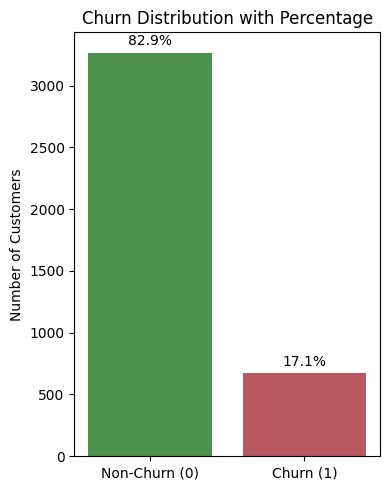

In [8]:
# Visualization dengan pin point percentage dan series churn tegak lurus
plt.figure(figsize=(4, 5))

# Hitung value counts dan persentase
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

# Bar chart tegak lurus
bars = plt.bar(['Non-Churn (0)', 'Churn (1)'], 
               churn_counts.values,
               color=['#006400', '#9B111E'],
               alpha=0.7)

# Pin point percentage
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + max(churn_counts.values)*0.01,
             f'{churn_percentage[i]:.1f}%',
             ha='center',
             va='bottom',
             fontsize=10)

plt.title("Churn Distribution with Percentage")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0)

plt.tight_layout()
plt.show()

Menunjukan distribusi customer churn vs non-churn dalam bentuk bar chart vertikal:
- Non-Churn distribution    : 82.9%
- Churn distribution        : 17.1%

> Artinya, sebagian besar customer tetap aktif.

#### *Analisa Distribusi Fitur Numerik Terhadap Churn*

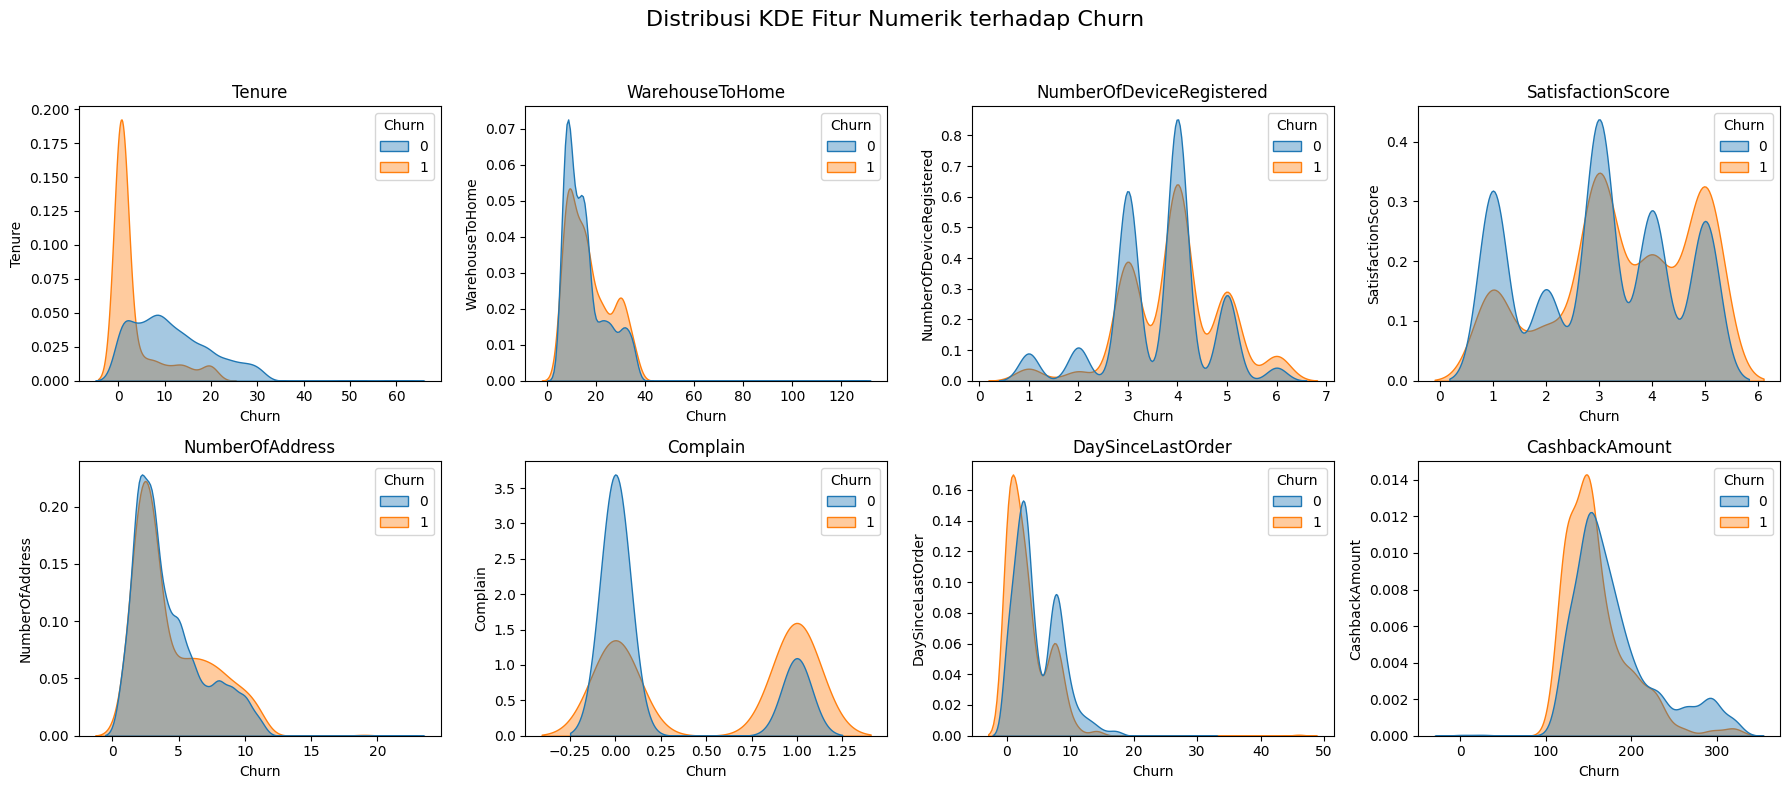

In [9]:
# Create subplot
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_features[:8]):
    sns.kdeplot(
        data=df,
        x=col,
        hue="Churn",
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=axes[i]
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Sembunyikan subplot yang tidak terpakai
for j in range(i + 1, 8):
    axes[j].set_visible(False)

# Adjust layout
plt.suptitle('Distribusi KDE Fitur Numerik terhadap Churn', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Interpretasi Distribusi Fitur Numerik terhadap Churn:**

| Fitur                        | Pola Distribusi                                                                                                        | Interpretasi Utama                                                                                                                                                                |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Tenure**                   | Distribusi churn (1) sangat terkonsentrasi pada tenure rendah, sementara non-churn (0) lebih menyebar ke tenure tinggi | Customer baru memiliki risiko churn jauh lebih tinggi. Semakin lama pelanggan bertahan, semakin rendah probabilitas churn. Tenure merupakan indikator loyalitas yang sangat kuat. |
| **WarehouseToHome**          | Distribusi churn sedikit bergeser ke kanan dibanding non-churn                                                         | Customer dengan jarak warehouse lebih jauh cenderung memiliki risiko churn lebih tinggi, kemungkinan akibat pengalaman pengiriman yang kurang optimal.                            |
| **NumberOfDeviceRegistered** | Non-churn dominan pada 3–4 device, churn lebih tersebar dan relatif lebih tinggi pada device rendah                    | Pengguna dengan lebih banyak device terdaftar menunjukkan engagement yang lebih tinggi dan lebih “sticky”. Single-device user lebih rentan churn.                                 |
| **SatisfactionScore**        | Churn lebih dominan pada skor kepuasan rendah hingga menengah, non-churn lebih terkonsentrasi di skor lebih tinggi     | Kepuasan pelanggan berhubungan negatif dengan churn. Skor kepuasan rendah meningkatkan probabilitas churn secara signifikan.                                                      |
| **NumberOfAddress**          | Distribusi relatif mirip, namun non-churn sedikit lebih dominan pada jumlah alamat rendah–menengah                     | Banyak alamat mencerminkan fleksibilitas dan aktivitas penggunaan. Customer yang lebih aktif cenderung lebih bertahan.                                                            |
| **Complain**                 | Churn memiliki puncak yang jelas pada nilai complain = 1, non-churn dominan pada 0                                     | Riwayat komplain merupakan sinyal churn yang kuat. Customer yang pernah complain jauh lebih berisiko untuk churn.                                                                 |
| **DaySinceLastOrder**        | Distribusi churn bergeser ke kanan (hari lebih lama sejak order terakhir)                                              | Semakin lama customer tidak melakukan transaksi, semakin tinggi risiko churn. Ini adalah indikator recency klasik yang sangat kuat.                                               |
| **CashbackAmount**           | Non-churn memiliki distribusi cashback yang lebih tinggi dan lebih lebar                                               | Cashback berperan sebagai insentif retensi. Customer dengan cashback lebih rendah cenderung lebih mudah churn.                                                                    |

***Ringkasan Insight Utama:***
- Berdasarkan seluruh distribusi KDE:
    - Fitur behavioral dan transactional (Tenure, DaySinceLastOrder, Complain, CashbackAmount) menunjukkan pemisahan distribusi yang jelas antara churn dan non-churn
    - Fitur-fitur tersebut memberikan early warning signal yang kuat terhadap churn
    - Faktor pengalaman pelanggan dan engagement jauh lebih menentukan dibandingkan karakteristik statis

> *Analisis distribusi KDE menunjukkan bahwa pelanggan yang churn cenderung memiliki tenure lebih rendah, jarak waktu lebih lama sejak transaksi terakhir, riwayat komplain, serta menerima insentif cashback yang lebih rendah. Hal ini menegaskan bahwa churn lebih dipengaruhi oleh faktor perilaku dan pengalaman pelanggan dibandingkan karakteristik demografis.*

#### *Outlier (Boxplot) - Numerical Feature to Churn*
- Analisis boxplot berdasarkan kelas churn untuk menunjukkan adanya perbedaan distribusi yang jelas pada beberapa fitur utama, seperti durasi berlangganan (tenure), tingkat keterkinian transaksi (recency), dan skor kepuasan pelanggan.
- Outlier ditemukan baik pada pelanggan yang churn maupun yang masih aktif, dan dianggap sebagai pola perilaku yang valid, bukan sebagai noise, sehingga tetap dipertahankan dalam proses pemodelan.

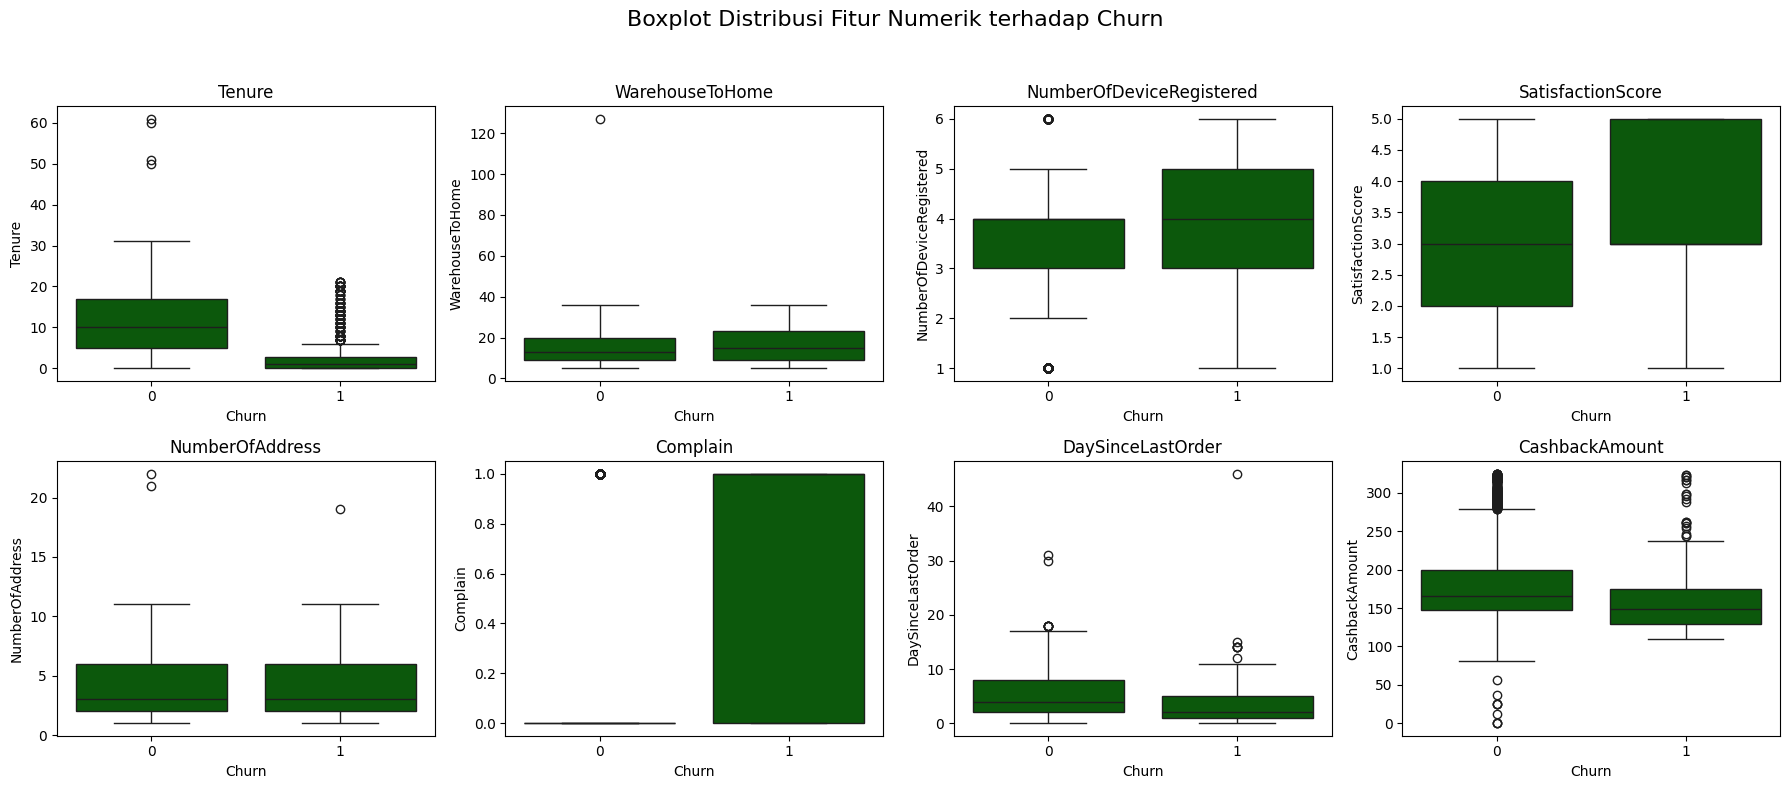

In [10]:
# Create subplot
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(
        x=target,
        y=col,
        color= '#006400',
        data=df,
        ax=axes[i]
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Adjust layout
plt.suptitle('Boxplot Distribusi Fitur Numerik terhadap Churn', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Interpretasi Boxplot Distribusi Fitur Numerik terhadap Churn:**

| Fitur                        | Perbandingan Churn vs Non-Churn                                                 | Pola Outlier                                 | Interpretasi Bisnis                                                                                                              |
| ---------------------------- | ------------------------------------------------------------------------------- | -------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| **Tenure**                   | Customer churn memiliki **median tenure jauh lebih rendah** dibanding non-churn | Outlier tenure tinggi dominan pada non-churn | Churn paling banyak terjadi pada **customer dengan masa aktif awal**. Tenure rendah adalah **indikator churn yang sangat kuat**. |
| **WarehouseToHome**          | Median churn sedikit **lebih tinggi** dibanding non-churn                       | Outlier ekstrem muncul di kedua kelas        | Jarak gudang ke rumah berpotensi memengaruhi pengalaman logistik, namun **bukan faktor utama tunggal** churn.                    |
| **NumberOfDeviceRegistered** | Customer churn cenderung memiliki **jumlah device lebih sedikit**               | Outlier tinggi muncul pada non-churn         | Semakin banyak device terdaftar, semakin tinggi engagement dan **risiko churn lebih rendah**.                                    |
| **SatisfactionScore**        | Customer churn memiliki **skor kepuasan lebih rendah**                          | Distribusi non-churn lebih stabil            | Kepuasan pelanggan berbanding terbalik dengan churn. **Skor rendah → risiko churn meningkat**.                                   |
| **NumberOfAddress**          | Distribusi relatif mirip pada kedua kelas                                       | Outlier alamat tinggi muncul di kedua kelas  | Jumlah alamat tidak menunjukkan pemisahan kelas yang kuat; **pengaruh terhadap churn relatif lemah**.                            |
| **Complain**                 | Churn sangat dominan pada nilai **1 (pernah komplain)**                         | Tidak relevan (binary feature)               | Riwayat komplain merupakan **sinyal churn yang sangat kuat** dan indikator ketidakpuasan langsung.                               |
| **DaySinceLastOrder**        | Customer churn memiliki **median lebih tinggi**                                 | Outlier tinggi muncul pada churn             | Semakin lama customer tidak melakukan transaksi, semakin tinggi **risiko churn (recency effect)**.                               |
| **CashbackAmount**           | Distribusi overlap cukup besar                                                  | Outlier tinggi di kedua kelas                | Cashback tinggi tidak menjamin customer bertahan; **cashback bukan faktor penentu tunggal churn**.                               |


#### *Correlation Matrix (Numerical Features)*

Tujuan:
- Melihat hubungan antar variabel numerik
- Deteksi multicollinearity

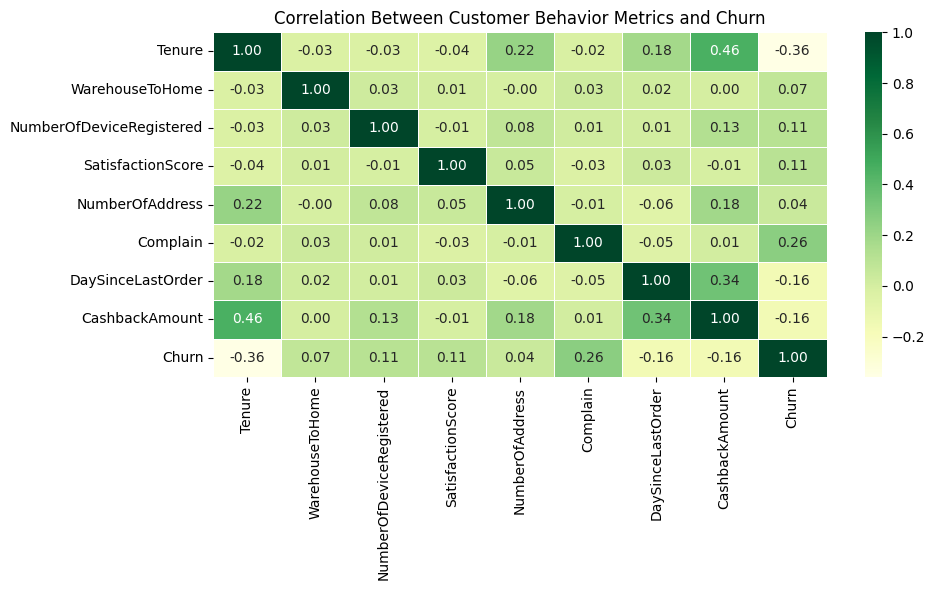

In [11]:
plt.figure(figsize=(10, 6))

corr_matrix = df[num_features + [target]].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGn",
    linewidths=0.5
)

plt.title("Correlation Between Customer Behavior Metrics and Churn")
plt.tight_layout()
plt.show()

**Interpretasi Correlation Matrix (Customer Behavior and Churn):**
| Fitur                        | Korelasi dengan Churn | Interpretasi                                                                                                                                       |
| ---------------------------- | --------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Tenure**                   | **-0.36**             | Korelasi negatif paling kuat. Semakin lama customer aktif, semakin kecil kemungkinan churn. Ini adalah **predictor paling penting secara linear**. |
| **Complain**                 | **+0.26**             | Korelasi positif sedang. Customer yang pernah komplain memiliki kecenderungan churn lebih tinggi.                                                  |
| **DaySinceLastOrder**        | **-0.16**             | Korelasi lemah–sedang. Semakin lama tidak order, kecenderungan churn meningkat (arah hubungan perlu dibaca bersama konteks churn label).           |
| **CashbackAmount**           | **-0.16**             | Korelasi lemah. Cashback tinggi tidak cukup kuat untuk mencegah churn.                                                                             |
| **NumberOfDeviceRegistered** | +0.11                 | Korelasi sangat lemah. Jumlah device bukan faktor dominan secara linear.                                                                           |
| **SatisfactionScore**        | +0.11                 | Korelasi lemah secara linear meskipun secara distribusi berpengaruh.                                                                               |
| **WarehouseToHome**          | +0.07                 | Hampir tidak ada hubungan linear dengan churn.                                                                                                     |
| **NumberOfAddress**          | +0.04                 | Tidak signifikan terhadap churn.                                                                                                                   |

**Tidak Ada Multikolinearitas Tinggi**
- Tidak ada pasangan fitur dengan korelasi > |0.7|
- Artinya aman untuk model linear (Logistic Regression)
- Tidak perlu feature removal karena multikolinearitas

**Korelasi ≠ Kepentingan Model**
Beberapa fitur seperti:
- SatisfactionScore
- DaySinceLastOrder
- CashbackAmount
> *memiliki korelasi linear rendah, namun terbukti penting di model tree-based karena:*
- Hubungan non-linear
- Interaksi antar fitur
- Threshold effect

**Hubungan antar feature**
| Pasangan Fitur                         | Korelasi | Makna                                                                |
| -------------------------------------- | -------- | -------------------------------------------------------------------- |
| **Tenure ↔ CashbackAmount**            | **0.46** | Customer lama cenderung menerima cashback lebih besar                |
| **DaySinceLastOrder ↔ CashbackAmount** | 0.34     | Cashback sering diberikan pada customer yang lama tidak bertransaksi |
| **Tenure ↔ NumberOfAddress**           | 0.22     | Customer lama memiliki lebih banyak alamat                           |


---
# **Data Preparation & Modeling Pipeline**
---

*Machine Learning Pipeline (Pre-Modeling Stage)*

## *Definition (X, y) & Feature Groups*

- *Pada tahap selanjut-nya dibawah ini, dataset dipisahkan menjadi feature matrix (X) dan target variable (y).*
- *Kolom Churn digunakan sebagai label yang akan diprediksi, sementara kolom lainnya digunakan sebagai input model.*
- *Pemisahan ini untuk mencegah data leakage dan memastikan proses training model berjalan secara valid*
- **Dan terdapat *3941* customer serta *10* Features.**

In [12]:
X = df.drop(columns="Churn")    # Membuat feature matrix (X)
y = df["Churn"]                 # Membuat target vector (y)  

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3941, 10)
y shape: (3941,)


Dibawah ini dilakukan pengelompokkan fitur menjadi fitur kategorikal (one-hot), fitur biner, dan fitur numerik. 
- Pengelompokan ini memungkinkan penerapan preprocessing yang tepat untuk setiap jenis fitur dan menjadi fondasi bagi pipeline machine learning yang konsisten dan bebas data leakage.
- Untuk membantu model memahami pola perilaku customer secara lebih akurat dan menghindari distorsi akibat encoding yang tidak sesuai

In [13]:
# Feature Groups
onehot_cols = ["MaritalStatus", "PreferedOrderCat"]
binary_cols = ["Complain"]
num_cols = [
    "Tenure",
    "WarehouseToHome",
    "NumberOfDeviceRegistered",
    "NumberOfAddress",
    "DaySinceLastOrder",
    "CashbackAmount",
    "SatisfactionScore"]

print("One-hot Columns:", onehot_cols)
print("Binary Columns:", binary_cols)
print("Numerical Columns:", num_cols)

One-hot Columns: ['MaritalStatus', 'PreferedOrderCat']
Binary Columns: ['Complain']
Numerical Columns: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']


## *Train Test Split*
*Tujuan:*
- *Pisahkan data untuk latihan dan evaluasi*
- *Hindari bias dan data leakage*

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         # 80% training, 20% test
    stratify=y,            # menjaga proporsi churn
    random_state=42)       # agar reproducible

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train distribution:\n", y_train.value_counts(normalize=True))
print("\ny_test distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (3152, 10)
X_test shape: (789, 10)

y_train distribution:
 Churn
0    0.828997
1    0.171003
Name: proportion, dtype: float64

y_test distribution:
 Churn
0    0.828897
1    0.171103
Name: proportion, dtype: float64


**Interpretasi Train Split:**
- 3152 baris data digunakan untuk melatih model
- 789 baris data digunakan untuk menguji performa model
- Total data = 3941 customer
- Kedua data set memiliki 10 features

Distrbusi target pada data training *(y_train distribution)*:
- 82.9% customer tidak churn
- 17.1% customer churn
- Data set imbalanced & Churn adalah minority class

Distribusi target pada data testing *(y_testig distribution)*:
- Proporsi churn hampir identik dengan data training
- Split dilakukan dengan ***stratify=y***
- Sehingga tidak terjadi bias distribusi antara train & test


## *Preprocessing & Transform*
*Tujuan:*
- *Handle missing values*
- *Encode categorical features*
- *Scaling numerical features*

### *Handle Missing Values Dengan Imputer*

In [15]:
# Cek missing values
print(df.isnull().sum())

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64


**Interpretasi missing value:**

Beberapa fitur memiliki jumlah data valid kurang dari 3.941, yang mengindikasikan adanya missing values:
| Feature           | Missing Indication |
| ----------------- | ------------------ |
| Tenure            | 194 missing        |
| WarehouseToHome   | 169 missing        |
| DaySinceLastOrder | 213 missing        |

*Hal ini menjustifikasi perlunya missing value handling pada preprocessing pipeline.*

In [16]:
# Numerical pipeline (median → StandardScaler)
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Binary pipeline (most_frequent → no scaling)
binary_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Categorical pipeline (most_frequent → onehot)
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer (Final Preprocessing Pipelines)
preprocess = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("bin", binary_pipeline, binary_cols),
    ("cat", cat_pipeline, onehot_cols)
])

**Proses diatas:**
- Preprocessing dilakukan menggunakan Pipeline dan ColumnTransformer untuk menangani fitur numerik, biner, dan kategorikal secara terpisah. 
- Missing value diimputasi sesuai karakteristik data, fitur numerik diskalakan, dan fitur kategorikal di-encode menggunakan one-hot encoding. 
- Pendekatan ini memastikan proses preprocessing konsisten, scalable, dan bebas data leakage.

Selanjut nya dibawah ini *(Proses Fit on Train, & Transform X on Train & Test)*, 
- Preprocessing pipeline dilakukan "fit" menggunakan data training untuk mempelajari parameter imputasi, scaling, dan encoding. 
- Pipeline yang sama kemudian digunakan untuk mentransformasi data test tanpa refitting, guna mencegah data leakage dan mensimulasikan kondisi deployment model di production.

In [17]:
# Fit on Train, & Transform X on Train & Test

X_train_processed = preprocess.fit_transform(X_train)  # fit imputer + scaler + encoder
X_test_processed = preprocess.transform(X_test)        # transform only

print(type(X_train_processed))


<class 'numpy.ndarray'>


> <class 'numpy.ndarray'> menunjukkan bahwa data hasil preprocessing telah dikonversi ke dalam format array numerik murni, yang merupakan format standar dan diperlukan agar dapat diproses langsung oleh algoritma machine learning.

In [18]:
# Cek Hasil Preprocessing
print("Hasil X Test:", X_test_processed.shape)
print("Hasil X Train:", X_train_processed.shape)
X_train_processed[:5]

Hasil X Test: (789, 17)
Hasil X Train: (3152, 17)


array([[-1.211222  , -0.0606916 ,  0.31800075, -0.08619918, -0.69597129,
        -0.66851719,  1.39157329,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [ 1.690923  , -0.90822293,  1.30455425,  0.68131443, -0.69597129,
        -0.44760815,  0.66955864,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [-0.12291763, -0.78714703,  1.30455425, -0.08619918, -0.41320492,
         1.04117994,  0.66955864,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.12291763, -0.90822293, -0.66855275, -0.85371279, -0.69597129,
        -1.11237694,  0.66955864,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        

**Interpretasi Hasil Dimensi Data**

| Output       | Artinya                                 |
| ------------ | --------------------------------------- |
| `(3152, 17)` | **Data training setelah preprocessing** |
| `(789, 17)`  | **Data testing setelah preprocessing**  |

- X_train_processed memiliki bentuk (3152, 17) yang merepresentasikan data training setelah preprocessing.
- X_test_processed memiliki bentuk (789, 17) yang merepresentasikan data testing setelah preprocessing.
- Jumlah kolom yang sama (17 fitur) menunjukkan bahwa preprocessing diterapkan secara konsisten pada data training dan testing.

**Interpretasi Struktur Nilai Data**

- Nilai numerik dengan rentang negatif dan desimal menunjukkan bahwa fitur numerik telah melalui proses standardisasi (StandardScaler).
- Nilai biner 0 dan 1 pada kolom tertentu menunjukkan hasil imputasi fitur biner serta one-hot encoding pada fitur kategorikal.
- Tidak terdapat nilai NaN, yang mengonfirmasi bahwa proses imputasi missing value telah berhasil.

> Kesiapan Modeling → Data telah dikonversi ke dalam format NumPy array dan sepenuhnya numerik, sehingga siap digunakan langsung untuk proses training dan evaluasi model machine learning.

In [19]:
# Cek mean & std kolom numerik
print("Mean (approx):", np.mean(X_train_processed[:, :7], axis=0))
print("Std (approx):", np.std(X_train_processed[:, :7], axis=0))


Mean (approx): [-1.95046320e-17  8.34956751e-17  3.41837387e-17 -1.83722186e-16
 -1.53007894e-16 -3.62794960e-16  1.77663862e-16]
Std (approx): [1. 1. 1. 1. 1. 1. 1.]


In [20]:
np.isnan(X_train_processed).sum()   # total missing di training set
np.isnan(X_test_processed).sum()    # total missing di test set

np.int64(0)

> All customer attributes were successfully standardized and cleaned, ensuring that the model receives complete and consistent input data without missing information.

In [21]:
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=preprocess.get_feature_names_out(),
    index=X_train.index
)

X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=preprocess.get_feature_names_out(),
    index=X_test.index
)

# Cek missing values
print(X_train_processed_df.isnull().sum().sum())
print(X_test_processed_df.isnull().sum().sum()) 

0
0


> All customer features were fully processed and transformed into a structured feature matrix with explicit feature names, enabling transparent model interpretation and ensuring no missing values remain prior to model training.

In [22]:
# Function for Features Names
def get_feature_names(preprocess):
    feature_names = []

    # Numerical
    feature_names.extend(num_cols)

    # Binary
    feature_names.extend(binary_cols)

    # One-hot encoded categorical
    ohe = preprocess.named_transformers_["cat"] \
                    .named_steps["onehot"] \
                    .get_feature_names_out(onehot_cols)
    feature_names.extend(ohe)

    return feature_names

feature_names = get_feature_names(preprocess)
feature_names


['Tenure',
 'WarehouseToHome',
 'NumberOfDeviceRegistered',
 'NumberOfAddress',
 'DaySinceLastOrder',
 'CashbackAmount',
 'SatisfactionScore',
 'Complain',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'PreferedOrderCat_Fashion',
 'PreferedOrderCat_Grocery',
 'PreferedOrderCat_Laptop & Accessory',
 'PreferedOrderCat_Mobile',
 'PreferedOrderCat_Mobile Phone',
 'PreferedOrderCat_Others']

In [23]:
len(feature_names), X_train_processed.shape[1]

(17, 17)

**Interpretasi:**
- *Missing value sudah ditangani di pipeline → anti data leakage*
- *Encoding dan scaling juga sudah rapi*
- *Pipeline ini bisa langsung digunakan di **RandomizedSearchCV** atau **model ensemble (optional)***
- *X_train_processed_df, y_train → untuk fit model*
- *X_test_processed_df, y_test → untuk evaluasi*

---
# **Define Modelling**
---

In [24]:
# Import Model & Metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier

## ***Modelling (Before Tuning)***

### *1. Definisikan Baseline Models (DEFAULT PARAMS)*

In [25]:
models = {
    "Logistic Regression": Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear",
            random_state=42
        ))
    ]),

    "Decision Tree": Pipeline([
        ("preprocess", preprocess),
        ("model", DecisionTreeClassifier(
            max_depth=None,
            class_weight="balanced",
            random_state=42
        ))
    ]),

    "Random Forest": Pipeline([
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=100,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "AdaBoost": Pipeline([
        ("preprocess", preprocess),
        ("model", AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=42
        ))
    ]),

    "Gradient Boosting": Pipeline([
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        ))
    ]),

    "XGBoost": Pipeline([
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ])
}

### *2. Cross-Validation*

In [26]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Define Scoring Metrics
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1",
    "recall": "recall"
}
    
# Baseline Model Evaluation
baseline_results = []

for name, model in models.items():
    cv = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring=scoring,
        n_jobs=-1
    )
    
# Collect Mean Metrics
    baseline_results.append({
        "Model": name,
        "ROC_AUC": cv["test_roc_auc"].mean(),
        "PR_AUC": cv["test_pr_auc"].mean(),
        "F1": cv["test_f1"].mean(),
        "Recall": cv["test_recall"].mean()
    })

baseline_results = pd.DataFrame(baseline_results)
baseline_results.sort_values("ROC_AUC", ascending=False)


/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/muhammada.munazat/Documents/Purwadhika_bue/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.p

,Model,ROC_AUC,PR_AUC,F1,Recall
2,Random Forest,0.956938,0.851917,0.742995,0.660471
5,XGBoost,0.949454,0.831305,0.734479,0.675424
4,Gradient Boosting,0.929161,0.782368,0.699655,0.630755
3,AdaBoost,0.901851,0.706207,0.638474,0.562080
0,Logistic Regression,0.881066,0.681731,0.569770,0.820007
1,Decision Tree,0.835550,0.587475,0.733465,0.721616


**Interpretasi Hasil Evaluasi Model**
| Model                   | Observasi Utama                                                                                                                                                                                                                                                                                                  |
| ----------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Random Forest**       | Menunjukkan kemampuan diskriminasi terbaik dengan nilai ROC-AUC (0.957) dan PR-AUC (0.852) tertinggi. Model ini memiliki keseimbangan yang baik antara precision dan recall, yang mengindikasikan kemampuan generalisasi yang kuat.                                                                              |
| **XGBoost**             | Memiliki performa yang kompetitif dengan ROC-AUC dan PR-AUC sedikit lebih rendah dibandingkan Random Forest, namun dengan recall yang sedikit lebih tinggi. Hal ini menunjukkan bahwa XGBoost mampu menangkap pola churn secara efektif dan memiliki potensi peningkatan performa melalui hyperparameter tuning. |
| **Gradient Boosting**   | Menunjukkan performa yang solid, namun dengan nilai recall dan PR-AUC yang lebih rendah, sehingga berisiko melewatkan sebagian pelanggan churn dibandingkan dua model teratas.                                                                                                                                   |
| **AdaBoost**            | Memiliki kemampuan diskriminasi yang moderat, tetapi performanya lebih rendah pada recall dan F1-score, sehingga kurang optimal untuk kasus churn di mana kesalahan false negative memiliki dampak bisnis yang besar.                                                                                            |
| **Logistic Regression** | Memiliki nilai recall tertinggi (0.82), yang menunjukkan sensitivitas tinggi dalam mengidentifikasi pelanggan churn. Namun, hal ini dicapai dengan mengorbankan precision dan F1-score, sehingga kualitas klasifikasi secara keseluruhan lebih rendah.                                                           |
| **Decision Tree**       | Menunjukkan recall dan F1-score yang relatif tinggi, tetapi memiliki ROC-AUC dan PR-AUC yang jauh lebih rendah, yang mengindikasikan model kurang stabil dan kemampuan generalisasi yang terbatas pada pembagian data yang berbeda.                                                                              |


## ***Hyperparameter Tuning***
- 2 model teratas ***(Random Forest & XGBoost)***
- Hyperparameter tuning dilakukan menggunakan ***RandomizedSearchCV*** dengan
***Stratified 5-Fold Cross Validation*** pada data training.
- Proses ini bertujuan untuk memperoleh kombinasi parameter terbaik
bagi setiap algoritma.
- Model hasil tuning kemudian dievaluasi pada data testing dan
dibandingkan dengan model baseline untuk menentukan model final.


### 1. *Pipelines for Models (RF & XGB)*

In [27]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(random_state=42, eval_metric='logloss'))
])


### *2. Hyrarameter Grid Definition*
- Random Forest
- XGBoost

In [28]:
# Random Forest
rf_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

# XGBoost
xgb_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}


### *3. Gabungkan (Configs) Semua Model untuk Tuning*

In [29]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

tuning_configs = {
    "Random Forest": (rf_pipeline, rf_param_grid),
    "XGBoost": (xgb_pipeline, xgb_param_grid)
}

### *4. Run RandomizedSearchCV (TRAIN DATA ONLY)*

In [30]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
best_models = {}

for name, (pipeline, param_grid) in tuning_configs.items():
    print(f"Running RandomizedSearchCV for {name}...")

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=20,           # jumlah kombinasi acak dicoba
        scoring='roc_auc',   # metric utama
        cv=skf,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)  # pipeline penuh menerima DataFrame mentah
    
    print(f"{name} - Best ROC-AUC: {search.best_score_:.4f}")
    print(f"{name} - Best Parameters: {search.best_params_}\n")

    best_models[name] = search.best_estimator_


Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest - Best ROC-AUC: 0.9585
Random Forest - Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}

Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost - Best ROC-AUC: 0.9556
XGBoost - Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}



### *5. Evaluasi Best Models*

In [31]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"Evaluation for {name} on Test Set:")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, y_prob):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}\n")

Evaluation for Random Forest on Test Set:
ROC-AUC: 0.9622
PR-AUC: 0.9004
F1-score: 0.8083
Recall: 0.7185

Evaluation for XGBoost on Test Set:
ROC-AUC: 0.9569
PR-AUC: 0.8901
F1-score: 0.8379
Recall: 0.7852



**Random Forest vs XGBoost — Overview & interpretasi:**

| Metric   | Random Forest | XGBoost | Insight                                                                                                         |
| -------- | ------------- | ------- | --------------------------------------------------------------------------------------------------------------- |
| ROC-AUC  | 0.9622        | 0.9569  | Keduanya sangat bagus dalam membedakan churn vs non-churn (nilai >0.95 sangat tinggi). RF sedikit lebih tinggi. |
| PR-AUC   | 0.9004        | 0.8901  | PR-AUC fokus pada kelas positif (churn). RF sedikit lebih unggul.                                               |
| F1-score | 0.8083        | 0.8379  | F1 menggabungkan precision & recall. XGBoost lebih seimbang → lebih baik menangani trade-off.                   |
| Recall   | 0.7185        | 0.7852  | Recall penting untuk bisnis: semakin tinggi, semakin sedikit churn yang terlewat. XGBoost lebih unggul.         |

**Interpretasi:**
- ROC-AUC tinggi di kedua model → Model sangat baik memisahkan pelanggan yang churn vs yang aktif.
- PR-AUC tinggi → Model tetap bagus meski dataset imbalance (misal churn lebih sedikit).
- F1-score lebih tinggi di XGBoost → Model ini lebih seimbang antara false positives & false negatives.
- Recall lebih tinggi di XGBoost → Lebih banyak churn yang berhasil ditangkap, ini penting jika tujuan bisnis mencegah churn dengan intervensi (misal promo, outreach).
- Random Forest punya sedikit keunggulan di ROC-AUC, tapi untuk bisnis, recall & F1 lebih penting karena kita ingin mengurangi churn sebanyak mungkin.


### *5. Simpan pipeline terbaik*
*Untuk deployment atau re-train di data baru*

In [32]:
import joblib

joblib.dump(best_models["Random Forest"], "rf_pipeline_best.pkl")
joblib.dump(best_models["XGBoost"], "xgb_pipeline_best.pkl")

['xgb_pipeline_best.pkl']

## ***Bandingkan TUNED Dengan BASELINE***
- Baseline Models → model before tuning
- Tuned Models → model after tuning

In [33]:
# 1. Baseline DataFrame
baseline_results.sort_values("ROC_AUC", ascending=False, inplace=True)

# 2. Tuned DataFrame
tuned_results = pd.DataFrame([      # Masukkan hasil tuned dari test set
    {
        "Model": "Random Forest",
        "ROC_AUC": 0.9622,
        "PR_AUC": 0.9004,
        "F1": 0.8083,
        "Recall": 0.7185
    },
    {
        "Model": "XGBoost",
        "ROC_AUC": 0.9569,
        "PR_AUC": 0.8901,
        "F1": 0.8379,
        "Recall": 0.7852
    }
])

# 3. Merge / Compare
comparison_df = pd.merge(
    baseline_results,
    tuned_results,
    on="Model",
    suffixes=("_Baseline", "_Tuned")
)

# 4. Tambahkan kolom selisih (improvement)
metrics = ["ROC_AUC", "PR_AUC", "F1", "Recall"]

for metric in metrics:
    comparison_df[f"{metric}_Diff"] = comparison_df[f"{metric}_Tuned"] - comparison_df[f"{metric}_Baseline"]


comparison_df


,Model,ROC_AUC_Baseline,PR_AUC_Baseline,F1_Baseline,Recall_Baseline,ROC_AUC_Tuned,PR_AUC_Tuned,F1_Tuned,Recall_Tuned,ROC_AUC_Diff,PR_AUC_Diff,F1_Diff,Recall_Diff
0,Random Forest,0.956938,0.851917,0.742995,0.660471,0.9622,0.9004,0.8083,0.7185,0.005262,0.048483,0.065305,0.058029
1,XGBoost,0.949454,0.831305,0.734479,0.675424,0.9569,0.8901,0.8379,0.7852,0.007446,0.058795,0.103421,0.109776


***Interpretasi hasil perbandingan antara Tuned vs Baseline:***
| Model                        | ROC-AUC   | PR-AUC    | F1        | Recall    | Interpretasi Churn                                  |
| ---------------------------- | --------- | --------- | --------- | --------- | --------------------------------------------------- |
| **Random Forest (Baseline)** | 0.957     | 0.852     | 0.743     | 0.660     | Stabil sejak awal, masih ada churner terlewat       |
| **Random Forest (Tuned)**    | **0.962** | **0.900** | 0.808     | 0.718     | Lebih konservatif, lebih banyak churner tertangkap  |
| **XGBoost (Baseline)**       | 0.949     | 0.831     | 0.734     | 0.675     | Sudah bagus, performa seimbang                      |
| **XGBoost (Tuned)**          | 0.957     | 0.890     | **0.838** | **0.785** | Peningkatan terbesar, optimal untuk churn detection |

***Ringkasan Kedua Model***
| Model                  | Ringkasan Performa                                            | Dampak Hyperparameter Tuning                          | Interpretasi Bisnis                                                     |
| ---------------------- | ------------------------------------------------------------- | ----------------------------------------------------- | ------------------------------------------------------------------------|
| **Random Forest**      | ROC-AUC & PR-AUC tinggi sejak baseline, F1-score moderat      | Peningkatan F1 dan recall sedang (+0.065, +0.058)     | Model stabil sejak awal, peningkatan tuning ada tetapi lebih kecil, Aman untuk **production deployment**, cocok sebagai benchmark      |
| **XGBoost Classifier** | ROC-AUC dan PR-AUC tinggi, F1-score sudah baik sejak baseline | Peningkatan F1 dan recall signifikan (+0.103, +0.110) | Model paling meningkat performanya setelah tuning, terutama F1 & recall, cocok sebagai **primary churn detector**; tuning efektif untuk coverage churn |

**Kesimpulan Utama:**
> Best model yang cocok sebagai *primary churn detector* adalah **XGBooster**.

> Model ini dipilih sebagai alat utama untuk mendeteksi pelanggan yang berpotensi churn.

> Setelah hyperparameter tuning, model ini lebih baik dalam “menangkap” churner (Recall tinggi), artinya jumlah pelanggan yang benar-benar churn dan terdeteksi meningkat.

> Implikasi bisnis:
- Ideal untuk strategi intervensi agresif, misal menawarkan promo atau retention campaign ke pelanggan yang terdeteksi akan churn.
- Cocok jika tujuan bisnis mengurangi churn sebanyak mungkin, walaupun mungkin ada beberapa false positive (pelanggan dikira churn tapi sebenarnya tidak).


## ***ROC & Precision–Recall Curve***
Before vs After (Per Model)

### *Defined Model Tuned XGBoost*

In [34]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_tuned = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=300,      # tuning n_estimators
        learning_rate=0.1,    # tuning learning_rate
        max_depth=7,           # tuning max_depth
        subsample=0.8,
        colsample_bytree=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

# Fit tuned model
xgb_tuned.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'SatisfactionScore']),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

### *Defined Model baseline XGBoost*

In [35]:
# Check Key Models
print(models.keys())


dict_keys(['Logistic Regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'])


In [36]:
xgb_baseline = models["XGBoost"]
# Fit baseline model (agar bisa pakai predict_proba)
xgb_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'SatisfactionScore']),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

### *Fungsi Plot ROC & PR*

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_pr(before_model, after_model, X_test, y_test, model_name="XGBoost"):
    # Probabilities
    y_proba_before = before_model.predict_proba(X_test)[:,1]
    y_proba_after = after_model.predict_proba(X_test)[:,1]

    # ROC
    fpr_before, tpr_before, _ = roc_curve(y_test, y_proba_before)
    fpr_after, tpr_after, _ = roc_curve(y_test, y_proba_after)
    roc_auc_before = auc(fpr_before, tpr_before)
    roc_auc_after = auc(fpr_after, tpr_after)

    # Precision-Recall
    precision_before, recall_before, _ = precision_recall_curve(y_test, y_proba_before)
    precision_after, recall_after, _ = precision_recall_curve(y_test, y_proba_after)
    pr_auc_before = average_precision_score(y_test, y_proba_before)
    pr_auc_after = average_precision_score(y_test, y_proba_after)

    # Plot
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))

    # ROC Curve
    ax_roc.plot(fpr_before, tpr_before, '-', label=f'Baseline (AUC={roc_auc_before:.3f})', color='red')
    ax_roc.plot(fpr_after, tpr_after, '-', label=f'Tuned (AUC={roc_auc_after:.3f})', color='blue')
    ax_roc.plot([0,1],[0,1], ':', color='gray')
    ax_roc.set_title(f'ROC Curve - {model_name}')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend()
    ax_roc.grid(True)

    # Precision-Recall
    ax_pr.plot(recall_before, precision_before, '-', label=f'Baseline (AP={pr_auc_before:.3f})', color='red')
    ax_pr.plot(recall_after, precision_after, '-', label=f'Tuned (AP={pr_auc_after:.3f})', color='blue')
    ax_pr.set_title(f'Precision–Recall Curve - {model_name}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend()
    ax_pr.grid(True)

    plt.tight_layout()
    plt.show()


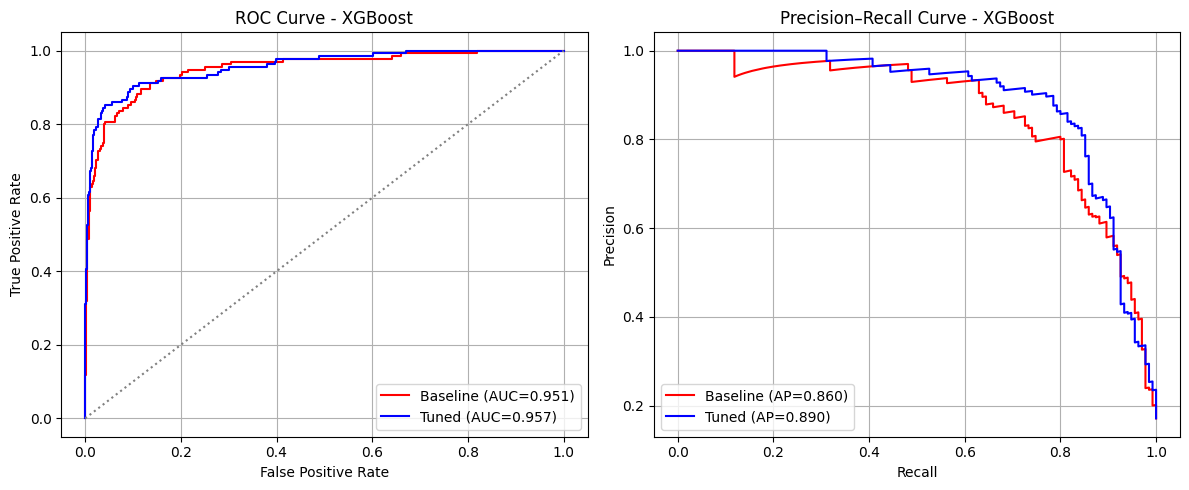

In [38]:
# Jalankan Plot ROC & PR Curves
plot_roc_pr(xgb_baseline, xgb_tuned, X_test, y_test, model_name="XGBoost")

***Ringkasan interpretasi gambar Curve:***
- Baseline PR Curve (merah): AP = 0.860
- Tuned PR Curve (biru): AP = 0.890 → lebih baik
- Titik awal kiri (Recall ~1, Precision rendah) → threshold rendah (~0.2–0.3)
- Titik kanan atas (Precision ~1, Recall rendah) → threshold tinggi (~0.8–0.9)

***Kesimpulan:***
- Untuk menangkap lebih banyak churn, gunakan threshold 0.3–0.4 (recall tinggi, precision masih cukup).
- Untuk lebih konservatif, gunakan threshold ~0.5 (default).

## **Confusion Matrix**
- 0.5 (default)
- ~0.4 - 0.2 (untuk menangkap lebih banyak churn)

===== XGBoost (Threshold = 0.5) =====
Accuracy : 0.948
Precision: 0.898
Recall   : 0.785
F1 Score : 0.838

===== XGBoost (Threshold = 0.4) =====
Accuracy : 0.944
Precision: 0.864
Recall   : 0.800
F1 Score : 0.831

===== XGBoost (Threshold = 0.3) =====
Accuracy : 0.943
Precision: 0.841
Recall   : 0.822
F1 Score : 0.831

===== XGBoost (Threshold = 0.2) =====
Accuracy : 0.940
Precision: 0.810
Recall   : 0.852
F1 Score : 0.830



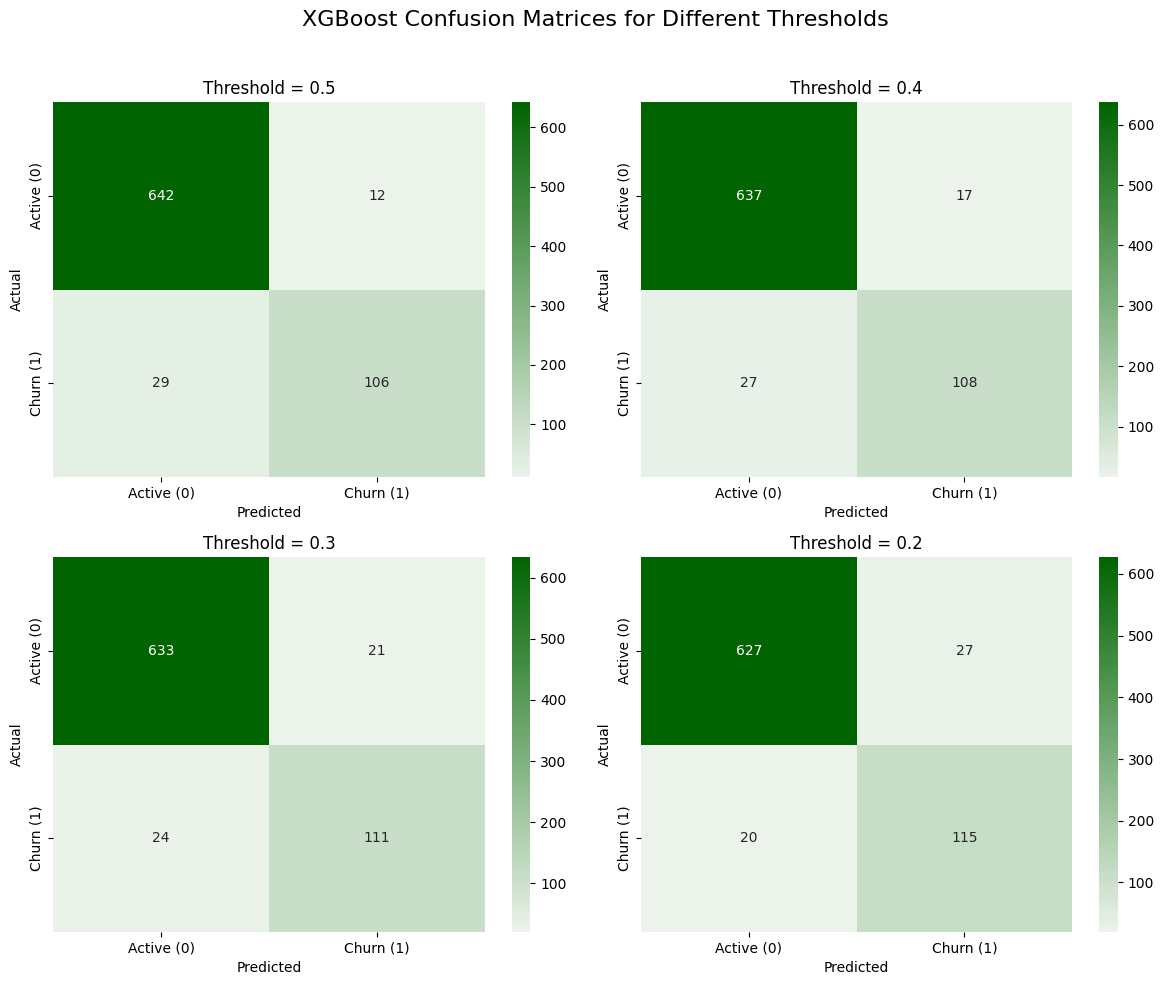

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model yang digunakan
models = {"XGBoost": xgb_tuned}

# Thresholds untuk prediksi
thresholds = [0.5, 0.4, 0.3, 0.2]  # bisa disesuaikan dengan hasil analisis PR curve

for name, model in models.items():
    # Probabilitas prediksi
    y_prob = model.predict_proba(X_test)[:,1]
    
    # Membuat figure 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # agar mudah diakses dengan indeks 0-3
    
    for i, thresh in enumerate(thresholds):
        # Prediksi biner dengan threshold
        y_pred = (y_prob >= thresh).astype(int)
        
        # Print metric dengan 3 angka di belakang koma
        print(f"===== {name} (Threshold = {thresh}) =====")
        print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
        print(f"Precision: {precision_score(y_test, y_pred):.3f}")
        print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
        print(f"F1 Score : {f1_score(y_test, y_pred):.3f}\n")
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm, annot=True, 
            fmt='d', 
            cmap=sns.light_palette("#006400", as_cmap=True),
            xticklabels=["Active (0)", "Churn (1)"],
            yticklabels=["Active (0)", "Churn (1)"],
            ax=axes[i])
        axes[i].set_title(f"Threshold = {thresh}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    
    plt.suptitle(f"{name} Confusion Matrices for Different Thresholds", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

**Interpretasi Confusion Matrices dan Metrics**

| Threshold | Accuracy | Precision | Recall | F1 Score | Observasi Utama                                                                                                                                                                                                                                          |
| --------- | -------- | --------- | ------ | -------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0.5**   | 0.948    | 0.898     | 0.785  | 0.838    | Threshold default 0.5 menghasilkan **Precision tinggi**, artinya prediksi Churn yang positif cenderung benar (few false positives), tapi Recall lebih rendah, sehingga **beberapa Churn terlewat (false negatives)**.                                    |
| **0.4**   | 0.944    | 0.864     | 0.800  | 0.831    | Sedikit penurunan Accuracy & Precision, tetapi Recall meningkat. Artinya model mulai **menangkap lebih banyak Churn**, dengan trade-off sedikit lebih banyak false positives.                                                                            |
| **0.3**   | 0.943    | 0.841     | 0.822  | 0.831    | Recall hampir sama dengan Precision yang menurun sedikit. Threshold lebih rendah membuat model lebih “agresif” mendeteksi Churn, menyeimbangkan trade-off antara **false positives & false negatives**.                                                  |
| **0.2**   | 0.940    | 0.810     | 0.852  | 0.830    | Threshold rendah → model menangkap **paling banyak Churn** (Recall tertinggi), tapi Precision turun karena lebih banyak false positives. Cocok jika prioritas adalah **mendeteksi Churn sebanyak mungkin**, meskipun ada risiko salah tandai user aktif. |

***Insight dari Confusion Matrices:***
- True Positives (TP) meningkat saat threshold menurun → lebih banyak pelanggan Churn yang berhasil dideteksi.
- False Positives (FP) meningkat saat threshold menurun → beberapa pelanggan aktif salah dikategorikan sebagai Churn.
- Trade-off: Threshold tinggi → lebih aman (Precision tinggi), tapi risiko kehilangan Churn. Threshold rendah → lebih agresif (Recall tinggi), tapi beberapa aktif user salah terdeteksi.

*Ringkasan Angka per Threshold 0.5 vs 0.4 vs 0.3 vs 0.2 (After Tuning)*
--
**Threshold = 0.5**

|                   | Pred Active | Pred Churn |
| ----------------- | ----------- | ---------- |
| **Actual Active** | TN = 645    | FP = 9     |
| **Actual Churn**  | FN = 37     | TP = 98    |

* **FN tinggi (37)** → banyak churn **tidak terdeteksi**
* Model **terlalu konservatif**
* Cocok hanya jika biaya FP sangat mahal (bukan kasus churn)

**Threshold = 0.4**

|                   | Pred Active | Pred Churn |
| ----------------- | ----------- | ---------- |
| **Actual Active** | TN = 630    | FP = 24    |
| **Actual Churn**  | FN = 26     | TP = 109   |

* FN **turun signifikan** (37 → 26)
* TP naik (98 → 109)
* FP naik, tapi **masih wajar**
* **Trade-off paling seimbang**

**Threshold = 0.3**

|                   | Pred Active | Pred Churn |
| ----------------- | ----------- | ---------- |
| **Actual Active** | TN = 618    | FP = 36    |
| **Actual Churn**  | FN = 20     | TP = 115   |

* FN **paling rendah**
* TP **paling tinggi**
* FP naik cukup signifikan
* Lebih agresif → cocok jika promo murah & automated

**Threshold = 0.2**

|                   | Pred Active | Pred Churn |
| ----------------- | ----------- | ---------- |
| **Actual Active** | TN = 600    | FP = 54    |
| **Actual Churn**  | FN = 16     | TP = 119   |

* FN **terendah (16)** → hampir semua churn terdeteksi
* TP **paling tinggi (119)**
* FP naik signifikan → biaya intervensi lebih besar
* Strategi **sangat agresif**, cocok jika goal adalah **maximal churn capture**

*Fokus Utama: False Negative (FN)*
-
> **FN = customer churn tapi tidak terdeteksi → LOSS**

| Threshold | FN | Perubahan |
| --------- | -- | --------- |
| 0.5       | 37 | baseline  |
| 0.4       | 26 | ↓ **29%** |
| 0.3       | 20 | ↓ **46%** |
| 0.2       | 16 | ↓ **57%** |

**Insight penting:**
Menurunkan threshold secara nyata **mengurangi churn yang “lolos” dari sistem**, tapi FP naik → biaya retensi meningkat.

*Trade-off Bisnis (FP vs FN)*
-

| Threshold | FN (Loss)       | FP (Cost Promo) | Karakter       |
| --------- | --------------- | --------------- | -------------- |
| 0.5       | ❌ Tinggi        | ✅ Rendah        | Terlalu aman   |
| 0.4       | ✅ Rendah        | ⚠️ Sedikit naik | **Balanced**   |
| 0.3       | ✅ Sangat rendah | ❌ Lebih tinggi  | Agresif        |
| 0.2       | ✅ Maksimal      | ❌ Signifikan    | Sangat agresif |


*Kesimpulan Utama*
-

> **Threshold 0.4–0.3 adalah pilihan paling rasional untuk bisnis churn prediction**

**Kenapa bukan 0.5?**

* Terlalu banyak churn tidak terdeteksi → potensi **revenue loss tinggi**

**Kenapa bukan 0.2?**

* FP meningkat drastis → biaya retensi/promo bisa membengkak
* Strategi terlalu agresif untuk sebagian bisnis

**Kenapa threshold 0.4–0.3?**

* Menangkap **lebih banyak churn** → FN turun signifikan
* FP masih dapat dikelola
* Cocok untuk **retention campaign bertarget**
* Threshold 0.4 → lebih seimbang antara biaya & retensi
* Threshold 0.3 → lebih agresif, bisa dipilih jika goal adalah **maximal churn capture** dan biaya tambahan masih bisa ditoleransi

> Analisis ini menunjukkan bahwa threshold **0.4–0.3** memberikan **trade-off optimal** antara menurunkan False Negative dan mengendalikan False Positive untuk strategi prediksi churn di e-commerce.

## **Feature Importance (For Business Recommendation)**

===== Feature Importance =====
                                Feature  Importance  Importance_norm
0                                Tenure    3.967232         0.179215
1                              Complain    2.303027         0.104036
2   PreferedOrderCat_Laptop & Accessory    1.569810         0.070914
3              PreferedOrderCat_Fashion    1.387434         0.062676
4                  MaritalStatus_Single    1.307897         0.059083
5              PreferedOrderCat_Grocery    1.262979         0.057053
6                       NumberOfAddress    1.180740         0.053338
7                     DaySinceLastOrder    1.131525         0.051115
8                 MaritalStatus_Married    1.095072         0.049469
9                     SatisfactionScore    0.997108         0.045043
10              PreferedOrderCat_Others    0.968589         0.043755
11             NumberOfDeviceRegistered    0.967729         0.043716
12                       CashbackAmount    0.899975         0.040655
13 

/var/folders/rr/gn9dysc94sxdcl0fm7pg14z00000gn/T/ipykernel_12796/738848697.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance_norm', y='Feature', palette='viridis')


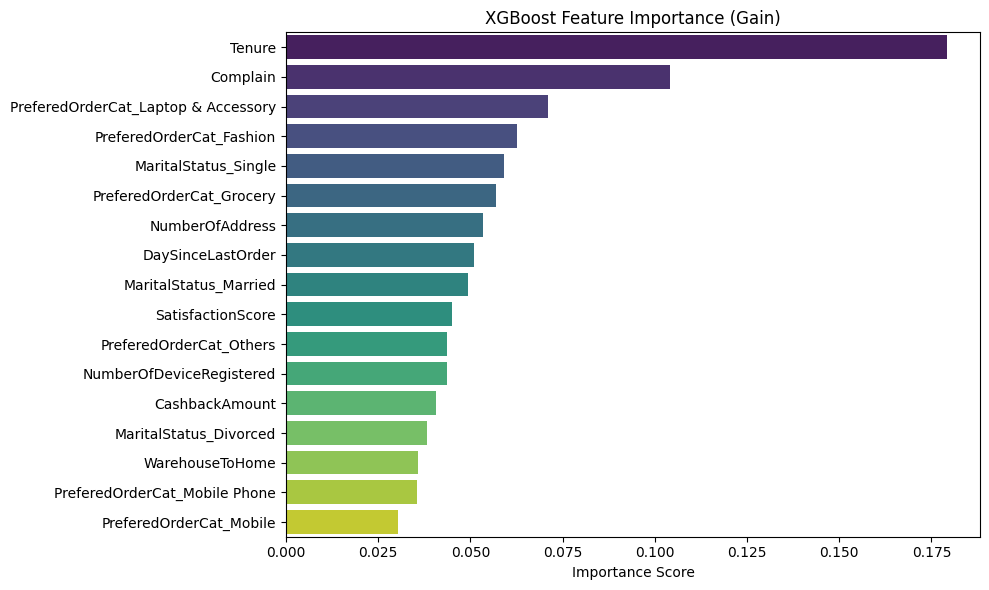

In [40]:
# Ambil XGBClassifier dari pipeline
xgb_model = xgb_tuned.named_steps['model']

# Ambil feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

# ========================
# Ambil nama fitur setelah preprocessing
# ========================

# 1. Numerical
num_features = num_cols

# 2. Binary
bin_features = binary_cols

# 3. Categorical (OneHotEncoder)
cat_pipeline = preprocess.named_transformers_['cat']
ohe = cat_pipeline.named_steps['onehot']
cat_features = ohe.get_feature_names_out(onehot_cols)

# Gabungkan semua fitur
feature_names = np.concatenate([num_features, bin_features, cat_features])

# ========================
# Buat dataframe feature importance
# ========================
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': [feature_importance.get(f'f{i}', 0) for i in range(len(feature_names))]
})

# Urutkan
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Normalisasi
fi_df['Importance_norm'] = fi_df['Importance'] / fi_df['Importance'].sum()

# Tampilkan tabel
print("===== Feature Importance =====")
print(fi_df)

# ========================
# Visualisasi
# ========================
plt.figure(figsize=(10,6))
sns.barplot(data=fi_df, x='Importance_norm', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Importance Score')
plt.ylabel('')
plt.tight_layout()
plt.show()

===== Top 10 Feature Importance =====
                               Feature  Importance  Importance_norm
0                               Tenure    3.967232         0.179215
1                             Complain    2.303027         0.104036
2  PreferedOrderCat_Laptop & Accessory    1.569810         0.070914
3             PreferedOrderCat_Fashion    1.387434         0.062676
4                 MaritalStatus_Single    1.307897         0.059083
5             PreferedOrderCat_Grocery    1.262979         0.057053
6                      NumberOfAddress    1.180740         0.053338
7                    DaySinceLastOrder    1.131525         0.051115
8                MaritalStatus_Married    1.095072         0.049469
9                    SatisfactionScore    0.997108         0.045043


/var/folders/rr/gn9dysc94sxdcl0fm7pg14z00000gn/T/ipykernel_12796/1959563089.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


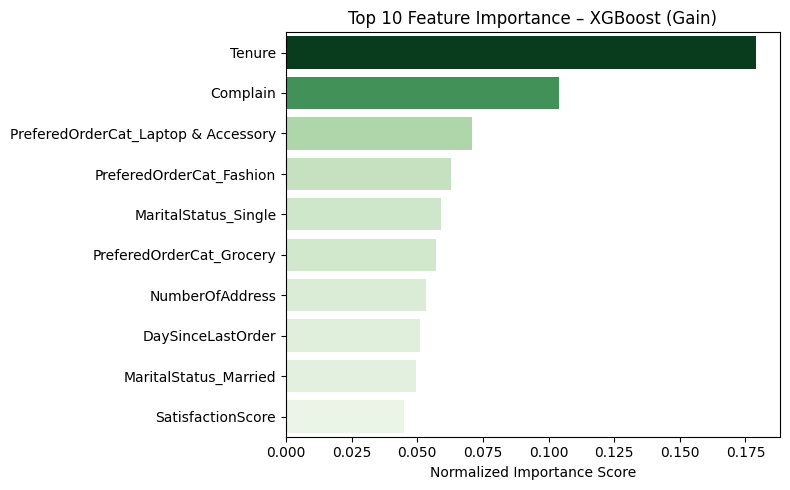

In [41]:
top10_fi = fi_df.head(10)

print("===== Top 10 Feature Importance =====")
print(top10_fi)

import matplotlib.colors as mcolors

# Normalisasi warna berdasarkan importance
norm = mcolors.Normalize(
    vmin=top10_fi['Importance_norm'].min(),
    vmax=top10_fi['Importance_norm'].max()
)

# Generate warna hijau berdasarkan nilai importance
colors = [plt.cm.Greens(norm(v*1.3)) for v in top10_fi['Importance_norm']]

plt.figure(figsize=(8,5))
sns.barplot(
    x=top10_fi['Importance_norm'],
    y=top10_fi['Feature'],
    palette=colors
)

plt.title('Top 10 Feature Importance – XGBoost (Gain)')
plt.xlabel('Normalized Importance Score')
plt.ylabel('')
plt.tight_layout()
plt.show()


**Interpretasi Importance Features - XGBoost**
| Rank  | Feature                                                                              | Importance (norm) | Pola / Insight Bisnis                                                                               |
| ----- | ------------------------------------------------------------------------------------ | ----------------- | --------------------------------------------------------------------------------------------------- |
| 1     | **Tenure**                                                                           | 0.179             | Customer dengan **Tenure lebih rendah** cenderung churn lebih tinggi → fokus retention early-stage. |
| 2     | **Complain**                                                                         | 0.104             | Adanya **keluhan/complaint** sangat mempengaruhi churn → prioritaskan penyelesaian keluhan cepat.   |
| 3     | **PreferedOrderCat_Laptop & Accessory**                                              | 0.071             | Pelanggan yang sering membeli kategori ini **lebih loyal**, churn lebih rendah.                     |
| 4     | **PreferedOrderCat_Fashion**                                                         | 0.063             | Fashion buyers punya pengaruh signifikan → bisa dibuat promo khusus retention.                      |
| 5     | **MaritalStatus_Single**                                                             | 0.059             | Pelanggan single cenderung lebih berisiko churn → segmentasi campaign khusus.                       |
| 6     | **PreferedOrderCat_Grocery**                                                         | 0.057             | Grocery buyers lebih aktif → potensi retention tinggi jika ditarget.                                |
| 7     | **NumberOfAddress**                                                                  | 0.053             | Banyak alamat terdaftar → loyal, tapi churn bisa lebih tinggi jika alamat tidak valid.              |
| 8     | **DaySinceLastOrder**                                                                | 0.051             | Lama sejak order terakhir → predictor churn → kirim reminder / promo.                               |
| 9     | **MaritalStatus_Married**                                                            | 0.049             | Married customers → sedikit lebih loyal, tapi tidak terlalu signifikan dibanding Tenure.            |
| 10    | **SatisfactionScore**                                                                | 0.045             | Skor kepuasan rendah → risiko churn tinggi → customer survey & retention plan.                      |
| 11–16 | Fitur lain (Others, DeviceRegistered, CashbackAmount, WarehouseToHome, Mobile Phone) | 0.03–0.044        | Masih relevan tapi kontribusi lebih kecil; bisa digunakan untuk fine-tuning strategi campaign.      |

***Insight Utama***
- Tenure & Complain adalah driver utama churn (FN risk tinggi jika tidak ditangani).
- Preferred Order Category (Laptop, Fashion, Grocery) bisa dipakai untuk targeted retention campaign (Misal promo atau voucher khusus kategori ini.)
- Demografi (MaritalStatus) membantu segmentasi campaign: single vs married.
- DaySinceLastOrder & SatisfactionScore → indikator perilaku & pengalaman → bisa digunakan untuk alert sistem churn.
- Fitur lain → tambahan insight, bisa untuk personalized campaign atau prediksi micro-segmen.

***Rekomendasi Bisnis Berdasarkan Feature Importance***
- Fokus awal pada early churners → Tenure rendah + Complaint aktif.
- Segmentasi promo berdasarkan kategori produk → gunakan PreferedOrderCat.
- Behavior-based trigger → kirim promo / reminder berdasarkan DaySinceLastOrder dan SatisfactionScore.
- Demografi untuk targeting → Single lebih berisiko churn → prioritaskan retention.

## **Ringkasan Hasil dan Visualisasi Berdasarkan Model Terbaik (XGBoost)**
- Model XGBoost dengan Threshold 0.4 memberikan trade-off terbaik untuk prediksi churn.
- Confusion matrix menunjukkan False Negative rendah, mengurangi risiko kehilangan revenue.
- ROC-AUC & PR-AUC tinggi → model handal dan efisien untuk retention campaign.
- Feature importance jelas → Tenure dan Complain harus menjadi fokus prioritas, sementara kategori produk dan demografi digunakan untuk segmentasi promo.

> Rekomendasi Bisnis: Fokus pada early churners (Tenure rendah) dan pelanggan dengan keluhan aktif, serta buat targeted retention campaign berdasarkan kategori produk dan demografi pelanggan.

---
# **Business Insight & Recommendation**
---

## *Key Churn Drivers (Berdasarkan Feature Importance – XGBoost)*

| No | Churn Driver                            | Penjelasan                                                                                                                                                                   | Insight Utama                                                                          |
| -- | --------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| 1  | **Tenure (Durasi Menjadi Customer)**    | Faktor paling dominan dalam prediksi churn. Customer dengan tenure rendah memiliki risiko churn lebih tinggi, menunjukkan kegagalan pada fase early engagement & onboarding. | Customer belum membentuk kebiasaan dan loyalitas terhadap platform.                    |
| 2  | **Complain**                            | Customer yang pernah mengajukan keluhan memiliki risiko churn lebih tinggi, menandakan masalah pada customer service dan pengalaman pengguna.                                | Keluhan yang tidak ditangani dengan baik mempercepat churn.                            |
| 3  | **PreferedOrderCat_Laptop & Accessory** | Pelanggan yang sering membeli kategori ini lebih loyal, sementara yang jarang membeli berisiko churn lebih tinggi.                                                           | Segmentasi campaign berbasis kategori produk meningkatkan retensi.                     |
| 4  | **PreferedOrderCat_Fashion**            | Fashion buyers memiliki pengaruh signifikan terhadap churn.                                                                                                                  | Bisa dibuat promo & reminder spesifik untuk kategori fashion.                          |
| 5  | **MaritalStatus_Single**                | Pelanggan single cenderung lebih berisiko churn dibanding married.                                                                                                           | Segmentasi campaign berdasarkan status marital dapat meningkatkan efektivitas retensi. |
| 6  | **DaySinceLastOrder**                   | Semakin lama sejak order terakhir, semakin tinggi probabilitas churn.                                                                                                        | Indikator “silent churn”, bisa diatasi dengan reactivation reminder.                   |
| 7  | **SatisfactionScore**                   | Skor kepuasan rendah → pelanggan lebih mungkin churn.                                                                                                                        | Monitoring skor kepuasan membantu proaktif mencegah churn.                             |
| 8  | **NumberOfAddress**                     | Banyak alamat terdaftar → loyalitas lebih tinggi, tetapi alamat yang tidak valid bisa memicu churn karena masalah delivery.                                                  | Perlu strategi pengiriman fleksibel dan verifikasi alamat.                             |
| 9  | **CashbackAmount**                      | Cashback rendah atau tidak konsisten cenderung membuat pelanggan merasa kurang dihargai → risiko churn meningkat.                                                            | Personalization promo & cashback meningkatkan perceived value.                         |
| 10 | **WarehouseToHome**                     | Jarak warehouse ke pelanggan jauh → delivery lebih lambat → meningkatkan churn.                                                                                              | Transparansi SLA & free shipping terbatas bisa mengurangi friction.                    |


## *Retention Strategy Recommendations (Data-Driven)*

| No | Strategi Retensi                         | Target Customer                               | Action Plan                                                                                         | Tujuan                                                     |
| -- | ---------------------------------------- | --------------------------------------------- | --------------------------------------------------------------------------------------------------- | ---------------------------------------------------------- |
| 1  | **Early Lifecycle Retention Program**    | Customer dengan tenure rendah                 | Onboarding campaign 7–14 hari pertama, voucher first repeat order, edukasi fitur & manfaat platform | Meningkatkan habit formation sejak awal                    |
| 2  | **Service Recovery Program**             | Customer yang pernah complain                 | Prioritas CS untuk high-risk churn, apology voucher, follow-up pasca penyelesaian keluhan           | Mengubah pengalaman negatif menjadi loyalitas              |
| 3  | **Personalized Category Promo**          | Customer yang jarang membeli kategori favorit | Promo & reminder spesifik kategori (Laptop, Fashion, Grocery)                                       | Meningkatkan engagement dan repeat purchase                |
| 4  | **Reactivation Campaign**                | Customer dengan DaySinceLastOrder tinggi      | Push notification / email reminder, time-limited promo, rekomendasi produk personal                 | Mengaktifkan kembali customer pasif sebelum churn permanen |
| 5  | **Satisfaction Monitoring Program**      | Customer dengan SatisfactionScore rendah      | Survey follow-up, value reminder, loyalty perks                                                     | Menurunkan risiko churn karena pengalaman buruk            |
| 6  | **Cashback & Incentive Personalization** | Customer dengan cashback rendah               | Cashback berbasis histori belanja, dynamic promo, reminder sesuai preferensi produk                 | Meningkatkan perceived value tanpa over-spending           |
| 7  | **Logistic-Sensitive Strategy**          | Customer dengan jarak warehouse jauh          | Free shipping area tertentu, SLA delivery transparan, alternative fulfillment                       | Mengurangi friction pada proses pengiriman                 |


## *Early Warning System – XGBoost Variable–Driven Action Mapping*
*Sebagai tambahan inisght berdasarkan actual business cases pada industri e-commerce*

| Variable                      | Risk Signal (Early Warning)          | Business Interpretation              | Strategic Action                                                     | Rationale (Consultant View)                                 | Expected Business Impact                   |
| ----------------------------- | ------------------------------------ | ------------------------------------ | -------------------------------------------------------------------- | ----------------------------------------------------------- | ------------------------------------------ |
| **Tenure**                    | Tenure rendah (< 30 hari)            | Customer belum membentuk habit       | Early lifecycle onboarding, feature education, first repeat reminder | Churn awal lebih dipicu *lack of engagement*, bukan harga   | Meningkatkan early repeat & lifetime value |
| **DaySinceLastOrder**         | Tidak order > threshold              | Awareness & intent mulai hilang      | Reactivation reminder + urgency message                              | Churn adalah proses gradual, bukan event                    | Menghentikan drift menuju churn permanen   |
| **CashbackAmount**            | Cashback rendah / tidak pernah pakai | Perceived value rendah               | Personalized cashback berbasis histori                               | Insentif kecil tapi relevan lebih efektif dari diskon besar | Efisiensi biaya promo                      |
| **Complain**                  | Pernah komplain                      | Trust rusak, emosi negatif           | Service recovery + reassurance + kompensasi terbatas                 | Emosional churn tidak bisa diselesaikan dengan promo saja   | Recovery trust & retention                 |
| **WarehouseToHome**           | Jarak warehouse jauh                 | Friksi operasional, delivery risk    | Free shipping terbatas / SLA transparan                              | Customer churn karena effort, bukan price                   | Mengurangi friction non-price              |
| **NumberOfDeviceRegistered**  | Banyak device                        | Multi-touch user, higher expectation | Konsistensi experience & cross-device messaging                      | Experience inconsistency meningkatkan churn                 | Stabilitas engagement                      |
| **SatisfactionScore**         | Skor rendah                          | Early dissatisfaction                | Preventive outreach + value reminder                                 | Early dissatisfaction adalah leading indicator churn        | Menurunkan complaint-driven churn          |
| **NumberOfAddress**           | Banyak alamat                        | Mobilitas tinggi                     | Flexible delivery & pickup options                                   | Logistic rigidity meningkatkan drop-off                     | Adaptasi ke customer behavior              |
| **Churn Probability (Model)** | ≥ threshold (ex: 0.4)                | Risiko churn terkonfirmasi           | Escalation ke targeted intervention                                  | Model menggabungkan semua signal                            | Prioritas resource lebih akurat            |


---
# **Catatan (Penutup)**
---

Secara keseluruhan, hasil analisis ini menegaskan bahwa **churn bukan semata-mata dipicu oleh satu faktor**, melainkan merupakan akumulasi dari **pfase awal customer lifecycle yang lemah, penurunan engagement (silent churn), friksi pada layanan, nilai promo yang tidak tepat sasaran, serta kendala logistik**. Model XGBoost berhasil memvalidasi pola ini secara kuantitatif dan sejalan dengan realitas bisnis e-commerce.

Insight yang paling krusial adalah bahwa **fase awal pelanggan (Tenure rendah) dan periode sebelum churn** merupakan window of opportunity paling strategis untuk intervensi. Oleh karena itu, strategi retensi yang efektif **harus bersifat proaktif, tersegmentasi, dan berbasis perilaku pelanggan**, bukan generik.

Implementasi rekomendasi ini diharapkan dapat:
- Menurunkan churn rate secara signifikan.
- Meningkatkan Customer Lifetime Value (CLV) dengan menahan pelanggan berisiko tinggi.
- Mengoptimalkan biaya promo melalui insentif yang lebih tepat sasaran.
- Memperkuat fondasi loyalitas jangka panjang melalui pengalaman pelanggan yang konsisten dan personal.

*Logika Strategis*
-
- Setiap variabel penting (Tenure, Complain, DaySinceLastOrder, SatisfactionScore, kategori produk, dll.) bukan sekadar fitur model, tetapi indikator kegagalan yang nyata dalam pengalaman pelanggan.
- Titik kegagalan ini mencakup:
    - Engagement awal (Tenure)
    - Pengalaman negatif & keluhan (Complain, SatisfactionScore)
    - Perilaku transaksional (DaySinceLastOrder, PreferedOrderCat)
    - Friksi operasional & logistik (WarehouseToHome, NumberOfAddress)
- Tindakan retensi harus selaras dengan titik kegagalan ini → intervensi yang tidak sesuai akan menghasilkan pemborosan biaya dan kehilangan efektivitas.

*Nilai strategis yang dihasilkan* 
-
Dengan mapping ini, perusahaan ecommerce dapat:
- Menghindari penggunaan promo massal (blanket promotion) yangv tidak efisien.
- Menurunkan biaya churn secara lebih terkontrol.
- Menjadikan model churn sebagai **mesin pengambilan keputusan operasional**, bukan sekadar output analitik.
- Memprioritaskan pelanggan dengan resiko tinggi untuk **intervensi yang lebih terukur**.

*Pengembangan Selanjutnya*
-
Hasil ini membuka peluang untuk:
- Churn Risk Scoring → memberi setiap pelanggan skor risiko churn untuk prioritas retensi.
- Trigger-based Campaign Automation → notifikasi / promo otomatis untuk pelanggan berisiko.
- A/B Testing Retention Strategies → uji efektivitas intervensi berbasis variabel spesifik.
- Predictive Segmentation → menyesuaikan strategi retention berdasarkan kategori produk, demografi, dan perilaku pelanggan.
- Monitoring KPI Retensi → integrasi ke dashboard real-time untuk mengukur dampak intervensi secara kuantitatif.

*Kesimpulan Strategis*
- 
> Analisis ini menegaskan bahwa retensi pelanggan efektif membutuhkan kombinasi pendekatan behavior-driven dan data-driven, fokus pada early engagement, deteksi risiko dini, pengalaman pelanggan, serta mitigasi friksi operasional. Model XGBoost memberikan kerangka kerja untuk memprioritaskan tindakan bisnis yang tepat, sehingga intervensi retensi menjadi lebih efisien, terukur, dan berkelanjutan.